In [11]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from torch.utils.data import ConcatDataset

import pywt
from scipy.signal import welch
from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    silhouette_score,
)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap
from imblearn.over_sampling import SMOTE
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from collections import Counter

In [2]:
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True) 
        std[std == 0] = 1e-8  
        
        return signal

    @staticmethod
    def resample(signal: np.ndarray,
                 factor: int,
                 method: str = 'mean') -> np.ndarray:
        """
        Downsample a multi-channel signal by aggregating each `factor` points into one.
    
        Args:
            signal: 2D array of shape (channels, time).
            factor: Number of consecutive points to aggregate (e.g., 12 to go from 5 min to 1 h).
            method: Aggregation method—either 'mean' or 'sum'.
    
        Returns:
            2D array of shape (channels, time//factor) with aggregated values.
    
        Note:
            This uses NumPy’s default aggregation behavior. If any NaN values are present
            within a group of `factor` points, the result for that group will be NaN.
            To ignore NaNs instead, you could replace `reshaped.mean(...)` with
            `np.nanmean(reshaped, axis=2)`.
        """
        # Number of EEG channels and original time length
        channels, length = signal.shape
    
        # Determine how many full groups of `factor` fit into the signal
        new_length = length // factor
    
        # Truncate any extra points so length is exactly divisible by factor
        trimmed = signal[:, : new_length * factor]
    
        # Reshape to (channels, new_length, factor) so we can aggregate over the last axis
        reshaped = trimmed.reshape(channels, new_length, factor)
    
        if method == 'mean':
            # Compute the average of each group of `factor` points
            return reshaped.mean(axis=2)
        elif method == 'sum':
            # Compute the sum of each group of `factor` points
            return reshaped.sum(axis=2)
        else:
            raise ValueError(f"Unsupported method: {method}")

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis
    

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz'],time_resolution='5min'):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment 
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=start_time
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
       
        # 计算下采样因子
        if time_resolution == '1h':
            self.resample_factor = 60 // 5  # 12
        else:
            self.resample_factor = 1
       
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules    
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly
        
        if self.resample_factor > 1:
            augmented_signal = EEGUtil.resample(augmented_signal,
                                     factor=self.resample_factor,
                                     method='mean')

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count
    

In [21]:
data_folder = '5min_smoothed_data/'  # 换成你的路径

# —— 1. 扫描所有 CSV 文件，收集列名并去掉 cpc —— 
all_columns = set()
for fname in os.listdir(data_folder):
    if fname.endswith('.csv'):
        df0 = pd.read_csv(os.path.join(data_folder, fname), nrows=0)
        all_columns.update(df0.columns.tolist())
cols = sorted(all_columns)
for drop in ['cpc', 'pat_ID', 'timestamp_hour']:
    if drop in cols:
        cols.remove(drop)

# —— 2. 从示例文件筛选数值型列 —— 
example_csv = next(f for f in os.listdir(data_folder) if f.endswith('.csv'))
example_df  = pd.read_csv(os.path.join(data_folder, example_csv), nrows=10)

numeric_cols = [
    col for col in cols
    if pd.api.types.is_numeric_dtype(example_df[col])
]

print("▶️ 最终用作 column_names 的数值型列 (共 {} 列)：".format(len(numeric_cols)))
print(numeric_cols)

▶️ 最终用作 column_names 的数值型列 (共 95 列)：
['BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD', 'alphakurtosis', 'alphameanrat', 'alphaminrat', 'alphapctrat', 'alphastdrat', 'avgspectent', 'avgspectkurt', 'betakurtosis', 'betameanrat', 'betaminrat', 'betapctrat', 'betastdrat', 'corrmean', 'd0MaxAmp', 'd0MaxMaxFourAmp', 'd0MeanMaxAmp', 'd0MeanMaxFourAmp', 'd0MeanVarAmp', 'd0VarMaxAmp', 'd0VarMaxFourAmp', 'd0VarMeanAmp', 'd0VarVarAmp', 'd1MaxAmp', 'd1MaxMaxFourAmp', 'd1MeanMaxAmp', 'd1MeanMaxFourAmp', 'd1MeanVarAmp', 'd1VarMaxAmp', 'd1VarMaxFourAmp', 'd1VarMeanAmp', 'd1VarVarAmp', 'd2MaxAmp', 'd2MaxMaxFourAmp', 'd2MeanMaxAmp', 'd2MeanMaxFourAmp', 'd2MeanVarAmp', 'd2VarMaxAmp', 'd2VarMaxFourAmp', 'd2VarMeanAmp', 'd2VarVarAmp', 'deltaalphamean', 'deltaalphamin', 'deltaalphapct', 'deltaalphastd', 'deltakurtosis', 'deltameanrat', 'deltaminrat', 'deltapctrat', 'deltastdrat', 'deltathetamean', 'deltathetamin', 'deltathetapct', 'deltathetastd', 'geomeanamp', 'harmmean

In [37]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GroupKFold

# —— 0. 设备设置 —— 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# —— 1. 超参数与数据集初始化 —— 
start_time   = 16
seq_length   = (68 - start_time) * 12  # 624 个 5min 窗口
#column_names = ['ssd', 'BCI', 'avgspectent', 'lv_l5']
column_names = numeric_cols
#column_names = ['BCI']
batch_size   = 32
epochs       = 100
n_splits     = 5
learning_rate= 1e-3
time_resolution='1h'   # 新增参数：'5min' 或 '1h'


# 创建 EEGDataset
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file='files_art_ssd_fts_predictions.csv',
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode='constant',
    use_labels=True,
    augment=False,
    num_good=1,
    num_bad=1,
    column_names=column_names,
    time_resolution=time_resolution
)


cuda
✅ Loaded 244 valid EEG files (filtered from 244 total)
Good Outcome: 44, Bad Outcome: 200


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import Counter

signals, labels, groups = [], [], []
for i in range(len(eeg_dataset)):
    sig_tensor, lab = eeg_dataset[i]        # 每次只有 ~1 ms
    signals.append(sig_tensor.numpy().T)    # (T', C)
    labels.append(lab)
    pid = eeg_dataset.valid_files[
              eeg_dataset.expanded_indices[i][0]
          ][0].split('.')[0]
    groups.append(pid)

X = np.stack(signals, dtype=np.float32)    # (244, T', C)
y = np.array(labels, dtype=np.float32)

# —— 3. 重建 groups 列表 —— 
# 由于 DataLoader shuffle=False，样本顺序等同于 eeg_dataset.expanded_indices 顺序
groups = [
    eeg_dataset.valid_files[e_idx][0].split('.')[0]
    for e_idx, _ in eeg_dataset.expanded_indices
]

print(f"After downsample: X.shape={X.shape}, y.shape={y.shape}, group count={len(groups)}")

# —— 4. 检测 NaN / Inf —— 
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: X 中存在无效值！")
    print("  NaN count:", np.isnan(X).sum())
    print("  Inf count:", np.isinf(X).sum())

nan_idxs = np.unique(np.where(np.isnan(X))[0])
print("含 NaN 的样本索引：", nan_idxs)

# 可视化包含 NaN 的样本
if False:
    for idx in nan_idxs:
        series = X[idx]          # shape = (T', C)
        Tprime, C = series.shape
        plt.figure(figsize=(8, 3))
        for c in range(C):
            plt.plot(series[:, c], label=f"feat{c}")
            nan_pos = np.where(np.isnan(series[:, c]))[0]
            plt.scatter(nan_pos, np.zeros_like(nan_pos), marker='x')
        plt.title(f"Sample {idx} with NaN")
        plt.legend()
        plt.show()

# —— 5. 用 0 填充 NaN 和 Inf —— 
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print("填充后：NaN count =", np.isnan(X).sum(),
      "Inf count =", np.isinf(X).sum())


After downsample: X.shape=(244, 52, 95), y.shape=(244,), group count=244
  NaN count: 16464
  Inf count: 0
含 NaN 的样本索引： [  1   2   7  13  15  17  18  21  23  24  25  27  28  29  30  31  32  33
  35  41  42  44  45  46  49  50  52  54  55  56  59  60  61  62  69  70
  71  73  74  77  78  79  80  81  82  85  86  87  88  89  92  94  96 100
 103 106 107 108 109 111 112 115 116 117 118 119 121 124 125 129 130 132
 133 136 138 139 140 142 143 144 146 147 148 149 150 152 153 154 155 156
 157 160 162 163 164 165 168 169 170 171 174 177 178 179 182 183 186 187
 188 192 193 199 203 204 206 207 209 212 214 215 216 217 219 222 223 225
 226 227 228 229 230 231 233 234 235 238 239 242 243]
填充后：NaN count = 0 Inf count = 0


In [41]:
import numpy as np
from sklearn.model_selection import GroupKFold
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# —— 6. 按时间戳分割并在每个小 dataset 上跑 GroupKFold CV —— 
T = X.shape[1]      # 时间戳总数
results = []        # 存 (t, mean_acc, mean_auc)

for t in range(T):
    # 6.1 构建第 t 个时间戳对应的小 dataset
    X_t = X[:, t, :]                           # shape = (N_patients, C)
    mask_t = ~(np.all(X_t == 0, axis=1))       # True 表示该病人在 t 时刻有非零数据
    X_sel = X_t[mask_t]
    y_sel = y[mask_t]
    groups_sel = np.array(groups)[mask_t]
    
    # 如果样本太少或只有一个类别，则跳过
    if len(y_sel) < 10 or len(np.unique(y_sel)) < 2:
        print(f"t = {t} 跳过：样本数 {len(y_sel)}, 类别数 {len(np.unique(y_sel))}")
        continue
    
    print(f"\n=== t = {t} (Hour {16+t}h)，样本数 {len(y_sel)} ===")
    
    # 6.2 在这个小 dataset 上做 GroupKFold
    cv = GroupKFold(n_splits=5)
    accs, aucs = [], []
    for fold, (tr_idx, te_idx) in enumerate(cv.split(X_sel, y_sel, groups_sel), 1):
        print(f"  --- Fold {fold} ---")
        X_tr, X_te = X_sel[tr_idx], X_sel[te_idx]
        y_tr, y_te = y_sel[tr_idx], y_sel[te_idx]
        print("   train balance:", Counter(y_tr), 
              "  test balance:", Counter(y_te))
        
        # 6.3 定义并编译 MLP 模型
        C = X_sel.shape[1]
        model = Sequential([
            Dense(64, input_shape=(C,), activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        
        # 6.4 训练
        model.fit(X_tr, y_tr,
                  batch_size=8,
                  epochs=10,      # 可调整
                  verbose=0)
        
        # 6.5 评估
        loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
        acc *= 100; auc *= 100
        print(f"    Acc: {acc:.2f}%, AUC: {auc:.2f}%")
        
        accs.append(acc)
        aucs.append(auc)
    
    # 6.6 汇总第 t 个时间戳
    mean_acc = np.mean(accs)
    mean_auc = np.mean(aucs)
    print(f"→ t = {t} 平均 Acc: {mean_acc:.2f}%, 平均 AUC: {mean_auc:.2f}%")
    results.append((t, mean_acc, mean_auc))

# —— 7. 打印所有时间戳总结 —— 
print("\n=== 各时间戳 CV 汇总 ===")
for t, acc, auc in results:
    print(f"t={t} (Hour {16+t}h): Mean Acc = {acc:.2f}%, Mean AUC = {auc:.2f}%")



=== t = 0 (Hour 16h)，样本数 159 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 105, 1.0: 22})   test balance: Counter({0.0: 22, 1.0: 10})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 68.75%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 99, 1.0: 28})   test balance: Counter({0.0: 28, 1.0: 4})
    Acc: 84.38%, AUC: 48.21%
  --- Fold 3 ---
   train balance: Counter({0.0: 100, 1.0: 27})   test balance: Counter({0.0: 27, 1.0: 5})
    Acc: 81.25%, AUC: 48.15%
  --- Fold 4 ---
   train balance: Counter({0.0: 104, 1.0: 23})   test balance: Counter({0.0: 23, 1.0: 9})
    Acc: 71.88%, AUC: 53.38%
  --- Fold 5 ---
   train balance: Counter({0.0: 100, 1.0: 28})   test balance: Counter({0.0: 27, 1.0: 4})
    Acc: 87.10%, AUC: 60.19%
→ t = 0 平均 Acc: 78.67%, 平均 AUC: 51.99%

=== t = 1 (Hour 17h)，样本数 163 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 103, 1.0: 27})   test balance: Counter({0.0: 28, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 84.85%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 105, 1.0: 25})   test balance: Counter({0.0: 26, 1.0: 7})
    Acc: 81.82%, AUC: 64.29%
  --- Fold 3 ---
   train balance: Counter({0.0: 103, 1.0: 27})   test balance: Counter({0.0: 28, 1.0: 5})
    Acc: 75.76%, AUC: 44.64%
  --- Fold 4 ---
   train balance: Counter({0.0: 105, 1.0: 26})   test balance: Counter({0.0: 26, 1.0: 6})
    Acc: 78.12%, AUC: 48.08%
  --- Fold 5 ---
   train balance: Counter({0.0: 108, 1.0: 23})   test balance: Counter({0.0: 23, 1.0: 9})
    Acc: 71.88%, AUC: 50.00%
→ t = 1 平均 Acc: 78.48%, 平均 AUC: 51.40%

=== t = 2 (Hour 18h)，样本数 166 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 105, 1.0: 27})   test balance: Counter({0.0: 28, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 79.41%, AUC: 48.21%
  --- Fold 2 ---
   train balance: Counter({0.0: 109, 1.0: 24})   test balance: Counter({0.0: 24, 1.0: 9})
    Acc: 72.73%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 108, 1.0: 25})   test balance: Counter({0.0: 25, 1.0: 8})
    Acc: 72.73%, AUC: 48.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 102, 1.0: 31})   test balance: Counter({0.0: 31, 1.0: 2})
    Acc: 84.85%, AUC: 45.16%
  --- Fold 5 ---
   train balance: Counter({0.0: 108, 1.0: 25})   test balance: Counter({0.0: 25, 1.0: 8})
    Acc: 75.76%, AUC: 56.25%
→ t = 2 平均 Acc: 77.09%, 平均 AUC: 49.53%

=== t = 3 (Hour 19h)，样本数 176 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 114, 1.0: 26})   test balance: Counter({0.0: 28, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 77.78%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 114, 1.0: 27})   test balance: Counter({0.0: 28, 1.0: 7})
    Acc: 77.14%, AUC: 48.21%
  --- Fold 3 ---
   train balance: Counter({0.0: 112, 1.0: 29})   test balance: Counter({0.0: 30, 1.0: 5})
    Acc: 80.00%, AUC: 46.67%
  --- Fold 4 ---
   train balance: Counter({0.0: 111, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 4})
    Acc: 88.57%, AUC: 60.89%
  --- Fold 5 ---
   train balance: Counter({0.0: 117, 1.0: 24})   test balance: Counter({0.0: 25, 1.0: 10})
    Acc: 74.29%, AUC: 55.00%
→ t = 3 平均 Acc: 79.56%, 平均 AUC: 52.15%

=== t = 4 (Hour 20h)，样本数 182 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 117, 1.0: 28})   test balance: Counter({0.0: 29, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 78.38%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 28})   test balance: Counter({0.0: 29, 1.0: 8})
    Acc: 83.78%, AUC: 62.50%
  --- Fold 3 ---
   train balance: Counter({0.0: 118, 1.0: 28})   test balance: Counter({0.0: 28, 1.0: 8})
    Acc: 77.78%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 116, 1.0: 30})   test balance: Counter({0.0: 30, 1.0: 6})
    Acc: 77.78%, AUC: 46.67%
  --- Fold 5 ---
   train balance: Counter({0.0: 116, 1.0: 30})   test balance: Counter({0.0: 30, 1.0: 6})
    Acc: 86.11%, AUC: 58.33%
→ t = 4 平均 Acc: 80.77%, 平均 AUC: 53.50%

=== t = 5 (Hour 21h)，样本数 187 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 123, 1.0: 26})   test balance: Counter({0.0: 27, 1.0: 11})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 71.05%, AUC: 52.69%
  --- Fold 2 ---
   train balance: Counter({0.0: 122, 1.0: 27})   test balance: Counter({0.0: 28, 1.0: 10})
    Acc: 71.05%, AUC: 53.04%
  --- Fold 3 ---
   train balance: Counter({0.0: 118, 1.0: 32})   test balance: Counter({0.0: 32, 1.0: 5})
    Acc: 81.08%, AUC: 46.88%
  --- Fold 4 ---
   train balance: Counter({0.0: 117, 1.0: 33})   test balance: Counter({0.0: 33, 1.0: 4})
    Acc: 91.89%, AUC: 62.50%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 30})   test balance: Counter({0.0: 30, 1.0: 7})
    Acc: 81.08%, AUC: 50.00%
→ t = 5 平均 Acc: 79.23%, 平均 AUC: 53.02%

=== t = 6 (Hour 22h)，样本数 190 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 123, 1.0: 29})   test balance: Counter({0.0: 30, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 76.32%, AUC: 57.50%
  --- Fold 2 ---
   train balance: Counter({0.0: 121, 1.0: 31})   test balance: Counter({0.0: 32, 1.0: 6})
    Acc: 73.68%, AUC: 51.04%
  --- Fold 3 ---
   train balance: Counter({0.0: 124, 1.0: 28})   test balance: Counter({0.0: 29, 1.0: 9})
    Acc: 78.95%, AUC: 55.56%
  --- Fold 4 ---
   train balance: Counter({0.0: 123, 1.0: 29})   test balance: Counter({0.0: 30, 1.0: 8})
    Acc: 78.95%, AUC: 48.33%
  --- Fold 5 ---
   train balance: Counter({0.0: 121, 1.0: 31})   test balance: Counter({0.0: 32, 1.0: 6})
    Acc: 84.21%, AUC: 56.77%
→ t = 6 平均 Acc: 78.42%, 平均 AUC: 53.84%

=== t = 7 (Hour 23h)，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 124, 1.0: 29})   test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 84.62%, AUC: 57.14%
  --- Fold 2 ---
   train balance: Counter({0.0: 123, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 87.18%, AUC: 65.15%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 26})   test balance: Counter({0.0: 28, 1.0: 10})
    Acc: 73.68%, AUC: 53.21%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 8})
    Acc: 78.95%, AUC: 54.58%
  --- Fold 5 ---
   train balance: Counter({0.0: 123, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 5})
    Acc: 84.21%, AUC: 48.48%
→ t = 7 平均 Acc: 81.73%, 平均 AUC: 55.72%

=== t = 8 (Hour 24h)，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 124, 1.0: 29})   test balance: Counter({0.0: 33, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.05%, AUC: 48.48%
  --- Fold 2 ---
   train balance: Counter({0.0: 125, 1.0: 28})   test balance: Counter({0.0: 32, 1.0: 7})
    Acc: 17.95%, AUC: 44.42%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 26})   test balance: Counter({0.0: 29, 1.0: 9})
    Acc: 50.00%, AUC: 51.92%
  --- Fold 4 ---
   train balance: Counter({0.0: 128, 1.0: 26})   test balance: Counter({0.0: 29, 1.0: 9})
    Acc: 76.32%, AUC: 53.83%
  --- Fold 5 ---
   train balance: Counter({0.0: 123, 1.0: 31})   test balance: Counter({0.0: 34, 1.0: 4})
    Acc: 78.95%, AUC: 44.12%
→ t = 8 平均 Acc: 61.05%, 平均 AUC: 48.55%

=== t = 9 (Hour 25h)，样本数 193 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 29})   test balance: Counter({0.0: 33, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 84.62%, AUC: 56.82%
  --- Fold 2 ---
   train balance: Counter({0.0: 125, 1.0: 29})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 84.62%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 125, 1.0: 29})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 79.49%, AUC: 54.04%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 23})   test balance: Counter({0.0: 26, 1.0: 12})
    Acc: 73.68%, AUC: 58.33%
  --- Fold 5 ---
   train balance: Counter({0.0: 125, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 5})
    Acc: 86.84%, AUC: 50.00%
→ t = 9 平均 Acc: 81.85%, 平均 AUC: 53.84%

=== t = 10 (Hour 26h)，样本数 196 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 24})   test balance: Counter({0.0: 29, 1.0: 11})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 75.00%, AUC: 57.37%
  --- Fold 2 ---
   train balance: Counter({0.0: 130, 1.0: 27})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 76.92%, AUC: 57.66%
  --- Fold 3 ---
   train balance: Counter({0.0: 129, 1.0: 28})   test balance: Counter({0.0: 32, 1.0: 7})
    Acc: 74.36%, AUC: 45.31%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 31})   test balance: Counter({0.0: 35, 1.0: 4})
    Acc: 79.49%, AUC: 44.29%
  --- Fold 5 ---
   train balance: Counter({0.0: 127, 1.0: 30})   test balance: Counter({0.0: 34, 1.0: 5})
    Acc: 79.49%, AUC: 45.59%
→ t = 10 平均 Acc: 77.05%, 平均 AUC: 50.04%

=== t = 11 (Hour 27h)，样本数 195 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 128, 1.0: 28})   test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 79.49%, AUC: 54.02%
  --- Fold 2 ---
   train balance: Counter({0.0: 129, 1.0: 27})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 74.36%, AUC: 46.77%
  --- Fold 3 ---
   train balance: Counter({0.0: 123, 1.0: 33})   test balance: Counter({0.0: 37, 1.0: 2})
    Acc: 94.87%, AUC: 73.65%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 27})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 74.36%, AUC: 46.77%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 25})   test balance: Counter({0.0: 29, 1.0: 10})
    Acc: 74.36%, AUC: 50.00%
→ t = 11 平均 Acc: 79.49%, 平均 AUC: 54.24%

=== t = 12 (Hour 28h)，样本数 197 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.50%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 129, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 25.00%, AUC: 48.70%
  --- Fold 3 ---
   train balance: Counter({0.0: 134, 1.0: 24})   test balance: Counter({0.0: 28, 1.0: 11})
    Acc: 74.36%, AUC: 54.55%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 31})   test balance: Counter({0.0: 35, 1.0: 4})
    Acc: 84.62%, AUC: 91.43%
  --- Fold 5 ---
   train balance: Counter({0.0: 129, 1.0: 29})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 71.79%, AUC: 56.06%
→ t = 12 平均 Acc: 67.65%, 平均 AUC: 60.15%

=== t = 13 (Hour 29h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 80.00%, AUC: 54.33%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 80.00%, AUC: 54.11%
  --- Fold 3 ---
   train balance: Counter({0.0: 130, 1.0: 30})   test balance: Counter({0.0: 35, 1.0: 5})
    Acc: 87.50%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 25.00%, AUC: 48.92%
  --- Fold 5 ---
   train balance: Counter({0.0: 134, 1.0: 26})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 80.00%, AUC: 55.56%
→ t = 13 平均 Acc: 70.50%, 平均 AUC: 52.58%

=== t = 14 (Hour 30h)，样本数 201 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 34, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 78.05%, AUC: 47.06%
  --- Fold 2 ---
   train balance: Counter({0.0: 135, 1.0: 26})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 72.50%, AUC: 46.77%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 30})   test balance: Counter({0.0: 35, 1.0: 5})
    Acc: 80.00%, AUC: 45.71%
  --- Fold 4 ---
   train balance: Counter({0.0: 134, 1.0: 27})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 70.00%, AUC: 43.75%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 85.00%, AUC: 50.00%
→ t = 14 平均 Acc: 77.11%, 平均 AUC: 46.66%

=== t = 15 (Hour 31h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 85.00%, AUC: 48.53%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 82.50%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 85.00%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 24})   test balance: Counter({0.0: 29, 1.0: 11})
    Acc: 75.00%, AUC: 54.55%
  --- Fold 5 ---
   train balance: Counter({0.0: 130, 1.0: 30})   test balance: Counter({0.0: 35, 1.0: 5})
    Acc: 85.00%, AUC: 48.57%
→ t = 15 平均 Acc: 82.50%, 平均 AUC: 50.33%

=== t = 16 (Hour 32h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 80.00%, AUC: 48.48%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 85.00%, AUC: 57.14%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 27.50%, AUC: 54.69%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 75.00%, AUC: 51.08%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 85.00%, AUC: 56.86%
→ t = 16 平均 Acc: 70.50%, 平均 AUC: 53.65%

=== t = 17 (Hour 33h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.50%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 80.00%, AUC: 54.11%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 80.00%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 70.00%, AUC: 42.42%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 82.50%, AUC: 48.53%
→ t = 17 平均 Acc: 79.00%, 平均 AUC: 49.01%

=== t = 18 (Hour 34h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 32.50%, AUC: 47.84%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 82.50%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 80.00%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 67.50%, AUC: 46.54%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 82.50%, AUC: 62.25%
→ t = 18 平均 Acc: 69.00%, 平均 AUC: 51.33%

=== t = 19 (Hour 35h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.50%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 82.50%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 70.00%, AUC: 48.44%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 82.50%, AUC: 50.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 82.50%, AUC: 48.53%
→ t = 19 平均 Acc: 80.00%, 平均 AUC: 49.39%

=== t = 20 (Hour 36h)，样本数 199 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 131, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.50%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 134, 1.0: 25})   test balance: Counter({0.0: 30, 1.0: 10})
    Acc: 75.00%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 130, 1.0: 29})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 85.00%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 128, 1.0: 31})   test balance: Counter({0.0: 36, 1.0: 4})
    Acc: 90.00%, AUC: 50.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 133, 1.0: 27})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 76.92%, AUC: 48.39%
→ t = 20 平均 Acc: 81.88%, 平均 AUC: 49.68%

=== t = 21 (Hour 37h)，样本数 199 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 134, 1.0: 25})   test balance: Counter({0.0: 29, 1.0: 11})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 70.00%, AUC: 51.25%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 28})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 80.00%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 129, 1.0: 30})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 85.00%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 128, 1.0: 31})   test balance: Counter({0.0: 35, 1.0: 5})
    Acc: 85.00%, AUC: 48.57%
  --- Fold 5 ---
   train balance: Counter({0.0: 130, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 84.62%, AUC: 50.00%
→ t = 21 平均 Acc: 80.92%, 平均 AUC: 49.97%

=== t = 22 (Hour 38h)，样本数 199 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 27})   test balance: Counter({0.0: 31, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 77.50%, AUC: 54.12%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 26})   test balance: Counter({0.0: 30, 1.0: 10})
    Acc: 75.00%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 129, 1.0: 30})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 85.00%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 32})   test balance: Counter({0.0: 36, 1.0: 4})
    Acc: 90.00%, AUC: 50.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 32, 1.0: 7})
    Acc: 79.49%, AUC: 48.44%
→ t = 22 平均 Acc: 81.40%, 平均 AUC: 50.51%

=== t = 23 (Hour 39h)，样本数 201 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 126, 1.0: 34})   test balance: Counter({0.0: 39, 1.0: 2})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 95.12%, AUC: 73.72%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 28})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 75.00%, AUC: 45.31%
  --- Fold 3 ---
   train balance: Counter({0.0: 136, 1.0: 25})   test balance: Counter({0.0: 29, 1.0: 11})
    Acc: 72.50%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 134, 1.0: 27})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 77.50%, AUC: 50.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 30})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 77.50%, AUC: 45.59%
→ t = 23 平均 Acc: 79.52%, 平均 AUC: 52.92%

=== t = 24 (Hour 40h)，样本数 202 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 133, 1.0: 28})   test balance: Counter({0.0: 33, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 80.49%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 126, 1.0: 35})   test balance: Counter({0.0: 40, 1.0: 1})
    Acc: 97.56%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 31})   test balance: Counter({0.0: 35, 1.0: 5})
    Acc: 87.50%, AUC: 48.57%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 26})   test balance: Counter({0.0: 30, 1.0: 10})
    Acc: 75.00%, AUC: 50.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 138, 1.0: 24})   test balance: Counter({0.0: 28, 1.0: 12})
    Acc: 67.50%, AUC: 48.21%
→ t = 24 平均 Acc: 81.61%, 平均 AUC: 49.36%

=== t = 25 (Hour 41h)，样本数 204 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 134, 1.0: 29})   test balance: Counter({0.0: 33, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 80.49%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 139, 1.0: 24})   test balance: Counter({0.0: 28, 1.0: 13})
    Acc: 68.29%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 32})   test balance: Counter({0.0: 36, 1.0: 5})
    Acc: 87.80%, AUC: 48.61%
  --- Fold 4 ---
   train balance: Counter({0.0: 130, 1.0: 33})   test balance: Counter({0.0: 37, 1.0: 4})
    Acc: 85.37%, AUC: 47.30%
  --- Fold 5 ---
   train balance: Counter({0.0: 134, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 82.50%, AUC: 50.00%
→ t = 25 平均 Acc: 80.89%, 平均 AUC: 49.18%

=== t = 26 (Hour 42h)，样本数 204 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 139, 1.0: 24})   test balance: Counter({0.0: 28, 1.0: 13})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 68.29%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 30})   test balance: Counter({0.0: 34, 1.0: 7})
    Acc: 82.93%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 32})   test balance: Counter({0.0: 36, 1.0: 5})
    Acc: 87.80%, AUC: 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 34})   test balance: Counter({0.0: 38, 1.0: 3})
    Acc: 58.54%, AUC: 62.28%
  --- Fold 5 ---
   train balance: Counter({0.0: 136, 1.0: 28})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 77.50%, AUC: 50.00%
→ t = 26 平均 Acc: 75.01%, 平均 AUC: 52.46%

=== t = 27 (Hour 43h)，样本数 205 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.93%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 7})
    Acc: 82.93%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 135, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 10})
    Acc: 70.73%, AUC: 50.16%
  --- Fold 4 ---
   train balance: Counter({0.0: 133, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 8})
    Acc: 82.93%, AUC: 56.25%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 7})
    Acc: 80.49%, AUC: 55.46%
→ t = 27 平均 Acc: 80.00%, 平均 AUC: 52.37%

=== t = 28 (Hour 44h)，样本数 208 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 136, 1.0: 30})   test balance: Counter({0.0: 32, 1.0: 10})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 76.19%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 139, 1.0: 27})   test balance: Counter({0.0: 29, 1.0: 13})
    Acc: 61.90%, AUC: 44.83%
  --- Fold 3 ---
   train balance: Counter({0.0: 132, 1.0: 34})   test balance: Counter({0.0: 36, 1.0: 6})
    Acc: 78.57%, AUC: 60.19%
  --- Fold 4 ---
   train balance: Counter({0.0: 131, 1.0: 36})   test balance: Counter({0.0: 37, 1.0: 4})
    Acc: 85.37%, AUC: 47.30%
  --- Fold 5 ---
   train balance: Counter({0.0: 134, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 7})
    Acc: 78.05%, AUC: 47.06%
→ t = 28 平均 Acc: 76.02%, 平均 AUC: 49.87%

=== t = 29 (Hour 45h)，样本数 206 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 136, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 12})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 69.05%, AUC: 48.33%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 7})
    Acc: 80.49%, AUC: 48.53%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 8})
    Acc: 78.05%, AUC: 48.48%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 7})
    Acc: 80.49%, AUC: 55.46%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 34})   test balance: Counter({0.0: 35, 1.0: 6})
    Acc: 85.37%, AUC: 50.00%
→ t = 29 平均 Acc: 78.69%, 平均 AUC: 50.16%

=== t = 30 (Hour 46h)，样本数 207 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 139, 1.0: 26})   test balance: Counter({0.0: 28, 1.0: 14})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 61.90%, AUC: 46.43%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 33})   test balance: Counter({0.0: 35, 1.0: 7})
    Acc: 80.95%, AUC: 48.57%
  --- Fold 3 ---
   train balance: Counter({0.0: 132, 1.0: 34})   test balance: Counter({0.0: 35, 1.0: 6})
    Acc: 75.61%, AUC: 44.29%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 34})   test balance: Counter({0.0: 35, 1.0: 6})
    Acc: 82.93%, AUC: 56.67%
  --- Fold 5 ---
   train balance: Counter({0.0: 133, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 7})
    Acc: 82.93%, AUC: 50.00%
→ t = 30 平均 Acc: 76.86%, 平均 AUC: 49.19%

=== t = 31 (Hour 47h)，样本数 210 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 78.57%, AUC: 48.53%
  --- Fold 2 ---
   train balance: Counter({0.0: 135, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 8})
    Acc: 78.57%, AUC: 48.53%
  --- Fold 3 ---
   train balance: Counter({0.0: 138, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 11})
    Acc: 71.43%, AUC: 52.79%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 9})
    Acc: 76.19%, AUC: 48.48%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 36})   test balance: Counter({0.0: 37, 1.0: 5})
    Acc: 83.33%, AUC: 45.95%
→ t = 31 平均 Acc: 77.62%, 平均 AUC: 48.86%

=== t = 32 (Hour 48h)，样本数 210 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 80.95%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 135, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 8})
    Acc: 73.81%, AUC: 45.59%
  --- Fold 3 ---
   train balance: Counter({0.0: 138, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 11})
    Acc: 73.81%, AUC: 52.93%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 9})
    Acc: 78.57%, AUC: 50.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 36})   test balance: Counter({0.0: 37, 1.0: 5})
    Acc: 85.71%, AUC: 47.30%
→ t = 32 平均 Acc: 78.57%, 平均 AUC: 49.16%

=== t = 33 (Hour 49h)，样本数 207 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 71.43%, AUC: 49.49%
  --- Fold 2 ---
   train balance: Counter({0.0: 129, 1.0: 36})   test balance: Counter({0.0: 39, 1.0: 3})
    Acc: 80.95%, AUC: 42.31%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 33})   test balance: Counter({0.0: 35, 1.0: 6})
    Acc: 82.93%, AUC: 55.48%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 30})   test balance: Counter({0.0: 32, 1.0: 9})
    Acc: 78.05%, AUC: 48.44%
  --- Fold 5 ---
   train balance: Counter({0.0: 139, 1.0: 27})   test balance: Counter({0.0: 29, 1.0: 12})
    Acc: 70.73%, AUC: 54.17%
→ t = 33 平均 Acc: 76.82%, 平均 AUC: 49.98%

=== t = 34 (Hour 50h)，样本数 207 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 78.57%, AUC: 50.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 130, 1.0: 35})   test balance: Counter({0.0: 38, 1.0: 4})
    Acc: 83.33%, AUC: 46.05%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 35})   test balance: Counter({0.0: 37, 1.0: 4})
    Acc: 87.80%, AUC: 48.65%
  --- Fold 4 ---
   train balance: Counter({0.0: 139, 1.0: 27})   test balance: Counter({0.0: 29, 1.0: 12})
    Acc: 70.73%, AUC: 48.28%
  --- Fold 5 ---
   train balance: Counter({0.0: 137, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 10})
    Acc: 75.61%, AUC: 55.00%
→ t = 34 平均 Acc: 79.21%, 平均 AUC: 49.60%

=== t = 35 (Hour 51h)，样本数 206 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 134, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 76.19%, AUC: 45.45%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 34})   test balance: Counter({0.0: 36, 1.0: 5})
    Acc: 70.73%, AUC: 38.89%
  --- Fold 3 ---
   train balance: Counter({0.0: 136, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 10})
    Acc: 78.05%, AUC: 55.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 135, 1.0: 30})   test balance: Counter({0.0: 32, 1.0: 9})
    Acc: 80.49%, AUC: 55.56%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 33})   test balance: Counter({0.0: 35, 1.0: 6})
    Acc: 78.05%, AUC: 45.71%
→ t = 35 平均 Acc: 76.70%, 平均 AUC: 48.12%

=== t = 36 (Hour 52h)，样本数 203 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 33})   test balance: Counter({0.0: 36, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.93%, AUC: 55.28%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 29})   test balance: Counter({0.0: 32, 1.0: 9})
    Acc: 73.17%, AUC: 49.48%
  --- Fold 3 ---
   train balance: Counter({0.0: 135, 1.0: 27})   test balance: Counter({0.0: 30, 1.0: 11})
    Acc: 68.29%, AUC: 49.55%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 82.50%, AUC: 54.33%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 75.00%, AUC: 44.12%
→ t = 36 平均 Acc: 76.38%, 平均 AUC: 50.55%

=== t = 37 (Hour 53h)，样本数 202 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 128, 1.0: 33})   test balance: Counter({0.0: 36, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.93%, AUC: 55.28%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 28})   test balance: Counter({0.0: 31, 1.0: 10})
    Acc: 73.17%, AUC: 51.77%
  --- Fold 3 ---
   train balance: Counter({0.0: 134, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 10})
    Acc: 70.00%, AUC: 46.67%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 33})   test balance: Counter({0.0: 35, 1.0: 5})
    Acc: 80.00%, AUC: 44.29%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 30})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 80.00%, AUC: 54.69%
→ t = 37 平均 Acc: 77.22%, 平均 AUC: 50.54%

=== t = 38 (Hour 54h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 75.00%, AUC: 51.08%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 77.50%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 70.00%, AUC: 41.18%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 75.00%, AUC: 45.45%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 72.50%, AUC: 51.97%
→ t = 38 平均 Acc: 74.00%, 平均 AUC: 47.94%

=== t = 39 (Hour 55h)，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 80.00%, AUC: 48.48%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 75.00%, AUC: 48.39%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 6})
    Acc: 70.00%, AUC: 54.90%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 7})
    Acc: 75.00%, AUC: 42.42%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 9})
    Acc: 75.00%, AUC: 48.39%
→ t = 39 平均 Acc: 75.00%, 平均 AUC: 48.52%

=== t = 40 (Hour 56h)，样本数 197 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 126, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 82.50%, AUC: 55.63%
  --- Fold 2 ---
   train balance: Counter({0.0: 127, 1.0: 30})   test balance: Counter({0.0: 32, 1.0: 8})
    Acc: 72.50%, AUC: 50.00%
  --- Fold 3 ---
   train balance: Counter({0.0: 125, 1.0: 33})   test balance: Counter({0.0: 34, 1.0: 5})
    Acc: 82.05%, AUC: 45.59%
  --- Fold 4 ---
   train balance: Counter({0.0: 130, 1.0: 28})   test balance: Counter({0.0: 29, 1.0: 10})
    Acc: 76.92%, AUC: 58.28%
  --- Fold 5 ---
   train balance: Counter({0.0: 128, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 84.62%, AUC: 62.50%
→ t = 40 平均 Acc: 79.72%, 平均 AUC: 54.40%

=== t = 41 (Hour 57h)，样本数 195 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 31})   test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 71.79%, AUC: 43.75%
  --- Fold 2 ---
   train balance: Counter({0.0: 126, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 28.21%, AUC: 45.16%
  --- Fold 3 ---
   train balance: Counter({0.0: 126, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 30.77%, AUC: 56.45%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 29})   test balance: Counter({0.0: 30, 1.0: 9})
    Acc: 58.97%, AUC: 48.89%
  --- Fold 5 ---
   train balance: Counter({0.0: 124, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 82.05%, AUC: 62.12%
→ t = 41 平均 Acc: 54.36%, 平均 AUC: 51.27%

=== t = 42 (Hour 58h)，样本数 194 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 69.23%, AUC: 52.82%
  --- Fold 2 ---
   train balance: Counter({0.0: 125, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 58.97%, AUC: 59.68%
  --- Fold 3 ---
   train balance: Counter({0.0: 123, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 82.05%, AUC: 55.30%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 29})   test balance: Counter({0.0: 30, 1.0: 9})
    Acc: 76.92%, AUC: 52.41%
  --- Fold 5 ---
   train balance: Counter({0.0: 125, 1.0: 31})   test balance: Counter({0.0: 31, 1.0: 7})
    Acc: 84.21%, AUC: 57.14%
→ t = 42 平均 Acc: 74.28%, 平均 AUC: 55.47%

=== t = 43 (Hour 59h)，样本数 194 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 30})   test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 69.23%, AUC: 42.19%
  --- Fold 2 ---
   train balance: Counter({0.0: 126, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 8})
    Acc: 76.92%, AUC: 46.77%
  --- Fold 3 ---
   train balance: Counter({0.0: 124, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 6})
    Acc: 84.62%, AUC: 63.64%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 9})
    Acc: 74.36%, AUC: 54.81%
  --- Fold 5 ---
   train balance: Counter({0.0: 126, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 7})
    Acc: 73.68%, AUC: 45.16%
→ t = 43 平均 Acc: 75.76%, 平均 AUC: 50.51%

=== t = 44 (Hour 60h)，样本数 193 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 126, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 71.79%, AUC: 53.15%
  --- Fold 2 ---
   train balance: Counter({0.0: 122, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 5})
    Acc: 84.62%, AUC: 48.53%
  --- Fold 3 ---
   train balance: Counter({0.0: 127, 1.0: 27})   test balance: Counter({0.0: 29, 1.0: 10})
    Acc: 74.36%, AUC: 48.28%
  --- Fold 4 ---
   train balance: Counter({0.0: 124, 1.0: 31})   test balance: Counter({0.0: 32, 1.0: 6})
    Acc: 84.21%, AUC: 50.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 125, 1.0: 30})   test balance: Counter({0.0: 31, 1.0: 7})
    Acc: 76.32%, AUC: 46.77%
→ t = 44 平均 Acc: 78.26%, 平均 AUC: 49.35%

=== t = 45 (Hour 61h)，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 76.92%, AUC: 53.89%
  --- Fold 2 ---
   train balance: Counter({0.0: 123, 1.0: 30})   test balance: Counter({0.0: 32, 1.0: 7})
    Acc: 69.23%, AUC: 58.93%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 26})   test balance: Counter({0.0: 27, 1.0: 11})
    Acc: 68.42%, AUC: 50.84%
  --- Fold 4 ---
   train balance: Counter({0.0: 122, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 5})
    Acc: 86.84%, AUC: 48.48%
  --- Fold 5 ---
   train balance: Counter({0.0: 122, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 5})
    Acc: 84.21%, AUC: 55.76%
→ t = 45 平均 Acc: 77.13%, 平均 AUC: 53.58%

=== t = 46 (Hour 62h)，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 124, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 71.79%, AUC: 43.55%
  --- Fold 2 ---
   train balance: Counter({0.0: 127, 1.0: 26})   test balance: Counter({0.0: 28, 1.0: 11})
    Acc: 46.15%, AUC: 36.20%
  --- Fold 3 ---
   train balance: Counter({0.0: 123, 1.0: 31})   test balance: Counter({0.0: 32, 1.0: 6})
    Acc: 60.53%, AUC: 35.94%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 28})   test balance: Counter({0.0: 29, 1.0: 9})
    Acc: 78.95%, AUC: 58.05%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 34})   test balance: Counter({0.0: 35, 1.0: 3})
    Acc: 68.42%, AUC: 67.14%
→ t = 46 平均 Acc: 65.17%, 平均 AUC: 48.18%

=== t = 47 (Hour 63h)，样本数 188 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 123, 1.0: 27})   test balance: Counter({0.0: 29, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 73.68%, AUC: 55.94%
  --- Fold 2 ---
   train balance: Counter({0.0: 123, 1.0: 27})   test balance: Counter({0.0: 29, 1.0: 9})
    Acc: 55.26%, AUC: 36.21%
  --- Fold 3 ---
   train balance: Counter({0.0: 119, 1.0: 31})   test balance: Counter({0.0: 33, 1.0: 5})
    Acc: 86.84%, AUC: 48.48%
  --- Fold 4 ---
   train balance: Counter({0.0: 119, 1.0: 32})   test balance: Counter({0.0: 33, 1.0: 4})
    Acc: 83.78%, AUC: 45.45%
  --- Fold 5 ---
   train balance: Counter({0.0: 124, 1.0: 27})   test balance: Counter({0.0: 28, 1.0: 9})
    Acc: 75.68%, AUC: 50.00%
→ t = 47 平均 Acc: 75.05%, 平均 AUC: 47.22%

=== t = 48 (Hour 64h)，样本数 186 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 122, 1.0: 26})   test balance: Counter({0.0: 29, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 36.84%, AUC: 50.96%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 32})   test balance: Counter({0.0: 34, 1.0: 3})
    Acc: 89.19%, AUC: 47.06%
  --- Fold 3 ---
   train balance: Counter({0.0: 120, 1.0: 29})   test balance: Counter({0.0: 31, 1.0: 6})
    Acc: 81.08%, AUC: 46.77%
  --- Fold 4 ---
   train balance: Counter({0.0: 121, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 7})
    Acc: 64.86%, AUC: 56.43%
  --- Fold 5 ---
   train balance: Counter({0.0: 124, 1.0: 25})   test balance: Counter({0.0: 27, 1.0: 10})
    Acc: 51.35%, AUC: 38.33%
→ t = 48 平均 Acc: 64.67%, 平均 AUC: 47.91%

=== t = 49 (Hour 65h)，样本数 184 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 120, 1.0: 27})   test balance: Counter({0.0: 30, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 78.38%, AUC: 56.90%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 4})
    Acc: 86.49%, AUC: 59.47%
  --- Fold 3 ---
   train balance: Counter({0.0: 119, 1.0: 28})   test balance: Counter({0.0: 31, 1.0: 6})
    Acc: 24.32%, AUC: 54.84%
  --- Fold 4 ---
   train balance: Counter({0.0: 124, 1.0: 23})   test balance: Counter({0.0: 26, 1.0: 11})
    Acc: 59.46%, AUC: 47.55%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 6})
    Acc: 50.00%, AUC: 43.33%
→ t = 49 平均 Acc: 59.73%, 平均 AUC: 52.42%

=== t = 50 (Hour 66h)，样本数 184 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 120, 1.0: 27})   test balance: Counter({0.0: 30, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 32.43%, AUC: 58.33%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 30})   test balance: Counter({0.0: 33, 1.0: 4})
    Acc: 86.49%, AUC: 70.45%
  --- Fold 3 ---
   train balance: Counter({0.0: 119, 1.0: 28})   test balance: Counter({0.0: 31, 1.0: 6})
    Acc: 83.78%, AUC: 56.72%
  --- Fold 4 ---
   train balance: Counter({0.0: 124, 1.0: 23})   test balance: Counter({0.0: 26, 1.0: 11})
    Acc: 29.73%, AUC: 47.38%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 28})   test balance: Counter({0.0: 30, 1.0: 6})
    Acc: 22.22%, AUC: 46.67%
→ t = 50 平均 Acc: 50.93%, 平均 AUC: 55.91%

=== t = 51 (Hour 67h)，样本数 182 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 117, 1.0: 28})   test balance: Counter({0.0: 32, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    Acc: 51.35%, AUC: 36.88%
  --- Fold 2 ---
   train balance: Counter({0.0: 119, 1.0: 26})   test balance: Counter({0.0: 30, 1.0: 7})
    Acc: 72.97%, AUC: 50.48%
  --- Fold 3 ---
   train balance: Counter({0.0: 124, 1.0: 22})   test balance: Counter({0.0: 25, 1.0: 11})
    Acc: 69.44%, AUC: 50.73%
  --- Fold 4 ---
   train balance: Counter({0.0: 119, 1.0: 27})   test balance: Counter({0.0: 30, 1.0: 6})
    Acc: 72.22%, AUC: 40.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 117, 1.0: 29})   test balance: Counter({0.0: 32, 1.0: 4})
    Acc: 75.00%, AUC: 40.62%
→ t = 51 平均 Acc: 68.20%, 平均 AUC: 43.74%

=== 各时间戳 CV 汇总 ===
t=0 (Hour 16h): Mean Acc = 78.67%, Mean AUC = 51.99%
t=1 (Hour 17h): Mean Acc = 78.48%, Mean AUC = 51.40%
t=2 (Hour 18h): Mean Acc = 77.09%, Mean AUC = 49.53%
t=3 (Hour 19h): Mean Acc = 79.56%, Mean AUC = 52.15%
t=4 (Hour 20h): Mean Acc = 80.77%, Mean AUC = 53.50%
t=5 (Hour 21h): Mean Acc = 79.23%, Mean AUC = 53.02%
t=6 (Hour 22h): Mean Acc = 78.42%, Mean AUC = 53

In [42]:
import numpy as np
from sklearn.model_selection import GroupKFold
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# 假设前面已经得到了：
#   X.shape = (N_patients, T, C)
#   y.shape = (N_patients,)
#   groups = [patient_id…]
# 并且做了第 0–5 步，现在我们在第 6 步，针对每个时间戳 t 做小 Dataset：

T = X.shape[1]
results = []

for t in range(T):
    # —— 构建第 t 个时间戳 Dataset —— 
    X_t = X[:, t, :]                        # (N_patients, C)
    mask = ~(np.all(X_t == 0, axis=1))      # 只保留非全零的
    X_sel = X_t[mask]
    y_sel = y[mask]
    g_sel = np.array(groups)[mask]

    if len(y_sel) < 10 or len(np.unique(y_sel)) < 2:
        print(f"t={t} 跳过：样本 {len(y_sel)} / 类别 {np.unique(y_sel)}")
        continue

    # —— 关键：把 features 维当成“时间步”，增加最后一个维度做为“通道” —— 
    # 这样输入给 LSTM 的 shape = (batch, C, 1)
    X_seq = X_sel[..., np.newaxis]  # (n_sel, C, 1)

    print(f"\n=== t={t} (Hour {16+t}h)，用 LSTM 做 5 折 CV，样本数 {len(y_sel)} ===")
    cv = GroupKFold(n_splits=5)
    accs, aucs = [], []

    for fold, (tr, te) in enumerate(cv.split(X_seq, y_sel, g_sel), 1):
        print(f"  --- Fold {fold} ---")
        X_tr, X_te = X_seq[tr], X_seq[te]
        y_tr, y_te = y_sel[tr], y_sel[te]
        print("   train balance:", Counter(y_tr),
              " test balance:", Counter(y_te))

        # —— 用你给的 LSTM 结构，只不过 input_shape 改成 (C,1) —— 
        C = X_seq.shape[2]
        model = Sequential([
            LSTM(64, input_shape=(X_seq.shape[1], 1), return_sequences=True),
            Dropout(0.2),
            LSTM(12, return_sequences=False),
            Dropout(0.2),
            Dense(1, activation='sigmoid')   # 二分类输出
        ])
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

        model.fit(X_tr, y_tr,
                  batch_size=8,
                  epochs=20,
                  verbose=0)

        loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
        accs.append(acc*100); aucs.append(auc*100)
        print(f"    Acc {acc*100:.2f}%, AUC {auc*100:.2f}%")

    mean_acc, mean_auc = np.mean(accs), np.mean(aucs)
    print(f"→ t={t} 平均 Acc {mean_acc:.2f}%, 平均 AUC {mean_auc:.2f}%")
    results.append((t, mean_acc, mean_auc))

print("\n=== 全部时间戳汇总 ===")
for t, a, u in results:
    print(f"t={t} (Hour {16+t}h): Acc {a:.2f}%, AUC {u:.2f}%")



=== t=0 (Hour 16h)，用 LSTM 做 5 折 CV，样本数 159 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 105, 1.0: 22})  test balance: Counter({0.0: 22, 1.0: 10})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 68.75%, AUC 53.18%
  --- Fold 2 ---
   train balance: Counter({0.0: 99, 1.0: 28})  test balance: Counter({0.0: 28, 1.0: 4})
    Acc 87.50%, AUC 33.04%
  --- Fold 3 ---
   train balance: Counter({0.0: 100, 1.0: 27})  test balance: Counter({0.0: 27, 1.0: 5})
    Acc 84.38%, AUC 72.59%
  --- Fold 4 ---
   train balance: Counter({0.0: 104, 1.0: 23})  test balance: Counter({0.0: 23, 1.0: 9})
    Acc 71.88%, AUC 68.12%
  --- Fold 5 ---
   train balance: Counter({0.0: 100, 1.0: 28})  test balance: Counter({0.0: 27, 1.0: 4})
    Acc 87.10%, AUC 36.57%
→ t=0 平均 Acc 79.92%, 平均 AUC 52.70%

=== t=1 (Hour 17h)，用 LSTM 做 5 折 CV，样本数 163 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 103, 1.0: 27})  test balance: Counter({0.0: 28, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 84.85%, AUC 54.29%
  --- Fold 2 ---
   train balance: Counter({0.0: 105, 1.0: 25})  test balance: Counter({0.0: 26, 1.0: 7})
    Acc 78.79%, AUC 45.05%
  --- Fold 3 ---
   train balance: Counter({0.0: 103, 1.0: 27})  test balance: Counter({0.0: 28, 1.0: 5})
    Acc 81.82%, AUC 78.93%
  --- Fold 4 ---
   train balance: Counter({0.0: 105, 1.0: 26})  test balance: Counter({0.0: 26, 1.0: 6})
    Acc 81.25%, AUC 73.40%
  --- Fold 5 ---
   train balance: Counter({0.0: 108, 1.0: 23})  test balance: Counter({0.0: 23, 1.0: 9})
    Acc 71.88%, AUC 58.70%
→ t=1 平均 Acc 79.72%, 平均 AUC 62.07%

=== t=2 (Hour 18h)，用 LSTM 做 5 折 CV，样本数 166 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 105, 1.0: 27})  test balance: Counter({0.0: 28, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.35%, AUC 43.75%
  --- Fold 2 ---
   train balance: Counter({0.0: 109, 1.0: 24})  test balance: Counter({0.0: 24, 1.0: 9})
    Acc 72.73%, AUC 62.50%
  --- Fold 3 ---
   train balance: Counter({0.0: 108, 1.0: 25})  test balance: Counter({0.0: 25, 1.0: 8})
    Acc 75.76%, AUC 50.25%
  --- Fold 4 ---
   train balance: Counter({0.0: 102, 1.0: 31})  test balance: Counter({0.0: 31, 1.0: 2})
    Acc 93.94%, AUC 45.16%
  --- Fold 5 ---
   train balance: Counter({0.0: 108, 1.0: 25})  test balance: Counter({0.0: 25, 1.0: 8})
    Acc 75.76%, AUC 53.75%
→ t=2 平均 Acc 80.11%, 平均 AUC 51.08%

=== t=3 (Hour 19h)，用 LSTM 做 5 折 CV，样本数 176 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 114, 1.0: 26})  test balance: Counter({0.0: 28, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 77.78%, AUC 44.87%
  --- Fold 2 ---
   train balance: Counter({0.0: 114, 1.0: 27})  test balance: Counter({0.0: 28, 1.0: 7})
    Acc 80.00%, AUC 54.85%
  --- Fold 3 ---
   train balance: Counter({0.0: 112, 1.0: 29})  test balance: Counter({0.0: 30, 1.0: 5})
    Acc 85.71%, AUC 59.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 111, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 4})
    Acc 88.57%, AUC 85.48%
  --- Fold 5 ---
   train balance: Counter({0.0: 117, 1.0: 24})  test balance: Counter({0.0: 25, 1.0: 10})
    Acc 71.43%, AUC 58.40%
→ t=3 平均 Acc 80.70%, 平均 AUC 60.52%

=== t=4 (Hour 20h)，用 LSTM 做 5 折 CV，样本数 182 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 117, 1.0: 28})  test balance: Counter({0.0: 29, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 78.38%, AUC 50.86%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 28})  test balance: Counter({0.0: 29, 1.0: 8})
    Acc 78.38%, AUC 52.37%
  --- Fold 3 ---
   train balance: Counter({0.0: 118, 1.0: 28})  test balance: Counter({0.0: 28, 1.0: 8})
    Acc 75.00%, AUC 72.99%
  --- Fold 4 ---
   train balance: Counter({0.0: 116, 1.0: 30})  test balance: Counter({0.0: 30, 1.0: 6})
    Acc 83.33%, AUC 49.44%
  --- Fold 5 ---
   train balance: Counter({0.0: 116, 1.0: 30})  test balance: Counter({0.0: 30, 1.0: 6})
    Acc 83.33%, AUC 78.33%
→ t=4 平均 Acc 79.68%, 平均 AUC 60.80%

=== t=5 (Hour 21h)，用 LSTM 做 5 折 CV，样本数 187 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 123, 1.0: 26})  test balance: Counter({0.0: 27, 1.0: 11})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 71.05%, AUC 64.65%
  --- Fold 2 ---
   train balance: Counter({0.0: 122, 1.0: 27})  test balance: Counter({0.0: 28, 1.0: 10})
    Acc 73.68%, AUC 51.96%
  --- Fold 3 ---
   train balance: Counter({0.0: 118, 1.0: 32})  test balance: Counter({0.0: 32, 1.0: 5})
    Acc 86.49%, AUC 84.38%
  --- Fold 4 ---
   train balance: Counter({0.0: 117, 1.0: 33})  test balance: Counter({0.0: 33, 1.0: 4})
    Acc 89.19%, AUC 75.00%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 30})  test balance: Counter({0.0: 30, 1.0: 7})
    Acc 81.08%, AUC 60.24%
→ t=5 平均 Acc 80.30%, 平均 AUC 67.24%

=== t=6 (Hour 22h)，用 LSTM 做 5 折 CV，样本数 190 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 123, 1.0: 29})  test balance: Counter({0.0: 30, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 78.95%, AUC 71.67%
  --- Fold 2 ---
   train balance: Counter({0.0: 121, 1.0: 31})  test balance: Counter({0.0: 32, 1.0: 6})
    Acc 84.21%, AUC 58.07%
  --- Fold 3 ---
   train balance: Counter({0.0: 124, 1.0: 28})  test balance: Counter({0.0: 29, 1.0: 9})
    Acc 76.32%, AUC 60.92%
  --- Fold 4 ---
   train balance: Counter({0.0: 123, 1.0: 29})  test balance: Counter({0.0: 30, 1.0: 8})
    Acc 76.32%, AUC 57.92%
  --- Fold 5 ---
   train balance: Counter({0.0: 121, 1.0: 31})  test balance: Counter({0.0: 32, 1.0: 6})
    Acc 84.21%, AUC 68.75%
→ t=6 平均 Acc 80.00%, 平均 AUC 63.47%

=== t=7 (Hour 23h)，用 LSTM 做 5 折 CV，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 124, 1.0: 29})  test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.05%, AUC 69.20%
  --- Fold 2 ---
   train balance: Counter({0.0: 123, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 66.92%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 26})  test balance: Counter({0.0: 28, 1.0: 10})
    Acc 73.68%, AUC 72.86%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 8})
    Acc 78.95%, AUC 53.12%
  --- Fold 5 ---
   train balance: Counter({0.0: 123, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 5})
    Acc 86.84%, AUC 82.42%
→ t=7 平均 Acc 81.23%, 平均 AUC 68.90%

=== t=8 (Hour 24h)，用 LSTM 做 5 折 CV，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 124, 1.0: 29})  test balance: Counter({0.0: 33, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 84.62%, AUC 77.27%
  --- Fold 2 ---
   train balance: Counter({0.0: 125, 1.0: 28})  test balance: Counter({0.0: 32, 1.0: 7})
    Acc 82.05%, AUC 43.30%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 26})  test balance: Counter({0.0: 29, 1.0: 9})
    Acc 76.32%, AUC 71.65%
  --- Fold 4 ---
   train balance: Counter({0.0: 128, 1.0: 26})  test balance: Counter({0.0: 29, 1.0: 9})
    Acc 76.32%, AUC 61.69%
  --- Fold 5 ---
   train balance: Counter({0.0: 123, 1.0: 31})  test balance: Counter({0.0: 34, 1.0: 4})
    Acc 89.47%, AUC 61.76%
→ t=8 平均 Acc 81.75%, 平均 AUC 63.13%

=== t=9 (Hour 25h)，用 LSTM 做 5 折 CV，样本数 193 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 29})  test balance: Counter({0.0: 33, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 84.62%, AUC 69.44%
  --- Fold 2 ---
   train balance: Counter({0.0: 125, 1.0: 29})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 53.54%
  --- Fold 3 ---
   train balance: Counter({0.0: 125, 1.0: 29})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 60.35%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 23})  test balance: Counter({0.0: 26, 1.0: 12})
    Acc 68.42%, AUC 52.88%
  --- Fold 5 ---
   train balance: Counter({0.0: 125, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 5})
    Acc 86.84%, AUC 76.67%
→ t=9 平均 Acc 81.82%, 平均 AUC 62.58%

=== t=10 (Hour 26h)，用 LSTM 做 5 折 CV，样本数 196 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 24})  test balance: Counter({0.0: 29, 1.0: 11})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 72.50%, AUC 69.12%
  --- Fold 2 ---
   train balance: Counter({0.0: 130, 1.0: 27})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 70.36%
  --- Fold 3 ---
   train balance: Counter({0.0: 129, 1.0: 28})  test balance: Counter({0.0: 32, 1.0: 7})
    Acc 82.05%, AUC 77.90%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 31})  test balance: Counter({0.0: 35, 1.0: 4})
    Acc 89.74%, AUC 78.93%
  --- Fold 5 ---
   train balance: Counter({0.0: 127, 1.0: 30})  test balance: Counter({0.0: 34, 1.0: 5})
    Acc 87.18%, AUC 74.12%
→ t=10 平均 Acc 82.19%, 平均 AUC 74.09%

=== t=11 (Hour 27h)，用 LSTM 做 5 折 CV，样本数 195 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 128, 1.0: 28})  test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.05%, AUC 72.77%
  --- Fold 2 ---
   train balance: Counter({0.0: 129, 1.0: 27})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 70.77%
  --- Fold 3 ---
   train balance: Counter({0.0: 123, 1.0: 33})  test balance: Counter({0.0: 37, 1.0: 2})
    Acc 94.87%, AUC 31.08%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 27})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 65.32%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 25})  test balance: Counter({0.0: 29, 1.0: 10})
    Acc 74.36%, AUC 63.28%
→ t=11 平均 Acc 82.05%, 平均 AUC 60.64%

=== t=12 (Hour 28h)，用 LSTM 做 5 折 CV，样本数 197 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 61.04%
  --- Fold 2 ---
   train balance: Counter({0.0: 129, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 84.85%
  --- Fold 3 ---
   train balance: Counter({0.0: 134, 1.0: 24})  test balance: Counter({0.0: 28, 1.0: 11})
    Acc 71.79%, AUC 67.53%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 31})  test balance: Counter({0.0: 35, 1.0: 4})
    Acc 89.74%, AUC 39.64%
  --- Fold 5 ---
   train balance: Counter({0.0: 129, 1.0: 29})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 58.08%
→ t=12 平均 Acc 82.23%, 平均 AUC 62.23%

=== t=13 (Hour 29h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 71.43%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 65.58%
  --- Fold 3 ---
   train balance: Counter({0.0: 130, 1.0: 30})  test balance: Counter({0.0: 35, 1.0: 5})
    Acc 87.50%, AUC 89.43%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 37.88%
  --- Fold 5 ---
   train balance: Counter({0.0: 134, 1.0: 26})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 76.70%
→ t=13 平均 Acc 82.50%, 平均 AUC 68.20%

=== t=14 (Hour 30h)，用 LSTM 做 5 折 CV，样本数 201 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 34, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.93%, AUC 73.74%
  --- Fold 2 ---
   train balance: Counter({0.0: 135, 1.0: 26})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 55.73%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 30})  test balance: Counter({0.0: 35, 1.0: 5})
    Acc 87.50%, AUC 89.71%
  --- Fold 4 ---
   train balance: Counter({0.0: 134, 1.0: 27})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 62.50%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 59.80%
→ t=14 平均 Acc 82.59%, 平均 AUC 68.30%

=== t=15 (Hour 31h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 85.00%, AUC 70.59%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 64.07%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 83.58%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 24})  test balance: Counter({0.0: 29, 1.0: 11})
    Acc 72.50%, AUC 52.51%
  --- Fold 5 ---
   train balance: Counter({0.0: 130, 1.0: 30})  test balance: Counter({0.0: 35, 1.0: 5})
    Acc 87.50%, AUC 78.57%
→ t=15 平均 Acc 82.50%, 平均 AUC 69.86%

=== t=16 (Hour 32h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 75.97%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 50.22%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 80.27%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 44.59%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 82.84%
→ t=16 平均 Acc 82.50%, 平均 AUC 66.78%

=== t=17 (Hour 33h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 80.95%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 54.98%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 85.74%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 57.14%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 82.35%
→ t=17 平均 Acc 82.50%, 平均 AUC 72.23%

=== t=18 (Hour 34h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 76.84%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 65.15%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 81.25%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 65.15%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 75.74%
→ t=18 平均 Acc 82.50%, 平均 AUC 72.83%

=== t=19 (Hour 35h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 79.87%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 57.14%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 27})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 80.27%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 57.14%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 74.75%
→ t=19 平均 Acc 82.50%, 平均 AUC 69.84%

=== t=20 (Hour 36h)，用 LSTM 做 5 折 CV，样本数 199 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 131, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 68.40%
  --- Fold 2 ---
   train balance: Counter({0.0: 134, 1.0: 25})  test balance: Counter({0.0: 30, 1.0: 10})
    Acc 75.00%, AUC 71.50%
  --- Fold 3 ---
   train balance: Counter({0.0: 130, 1.0: 29})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 65.69%
  --- Fold 4 ---
   train balance: Counter({0.0: 128, 1.0: 31})  test balance: Counter({0.0: 36, 1.0: 4})
    Acc 90.00%, AUC 82.64%
  --- Fold 5 ---
   train balance: Counter({0.0: 133, 1.0: 27})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 72.98%
→ t=20 平均 Acc 82.40%, 平均 AUC 72.24%

=== t=21 (Hour 37h)，用 LSTM 做 5 折 CV，样本数 199 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 134, 1.0: 25})  test balance: Counter({0.0: 29, 1.0: 11})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 72.50%, AUC 75.24%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 28})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 64.84%
  --- Fold 3 ---
   train balance: Counter({0.0: 129, 1.0: 30})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 85.05%
  --- Fold 4 ---
   train balance: Counter({0.0: 128, 1.0: 31})  test balance: Counter({0.0: 35, 1.0: 5})
    Acc 87.50%, AUC 64.29%
  --- Fold 5 ---
   train balance: Counter({0.0: 130, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 67.42%
→ t=21 平均 Acc 81.92%, 平均 AUC 71.37%

=== t=22 (Hour 38h)，用 LSTM 做 5 折 CV，样本数 199 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 27})  test balance: Counter({0.0: 31, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 77.50%, AUC 77.42%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 26})  test balance: Counter({0.0: 30, 1.0: 10})
    Acc 75.00%, AUC 68.67%
  --- Fold 3 ---
   train balance: Counter({0.0: 129, 1.0: 30})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 77.70%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 32})  test balance: Counter({0.0: 36, 1.0: 4})
    Acc 90.00%, AUC 81.60%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 32, 1.0: 7})
    Acc 82.05%, AUC 70.09%
→ t=22 平均 Acc 81.91%, 平均 AUC 75.09%

=== t=23 (Hour 39h)，用 LSTM 做 5 折 CV，样本数 201 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 126, 1.0: 34})  test balance: Counter({0.0: 39, 1.0: 2})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 95.12%, AUC 83.33%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 28})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 80.27%
  --- Fold 3 ---
   train balance: Counter({0.0: 136, 1.0: 25})  test balance: Counter({0.0: 29, 1.0: 11})
    Acc 72.50%, AUC 69.59%
  --- Fold 4 ---
   train balance: Counter({0.0: 134, 1.0: 27})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 71.33%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 30})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 78.92%
→ t=23 平均 Acc 82.02%, 平均 AUC 76.69%

=== t=24 (Hour 40h)，用 LSTM 做 5 折 CV，样本数 202 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 133, 1.0: 28})  test balance: Counter({0.0: 33, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 80.49%, AUC 73.86%
  --- Fold 2 ---
   train balance: Counter({0.0: 126, 1.0: 35})  test balance: Counter({0.0: 40, 1.0: 1})
    Acc 97.56%, AUC 86.25%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 31})  test balance: Counter({0.0: 35, 1.0: 5})
    Acc 87.50%, AUC 71.14%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 26})  test balance: Counter({0.0: 30, 1.0: 10})
    Acc 75.00%, AUC 58.83%
  --- Fold 5 ---
   train balance: Counter({0.0: 138, 1.0: 24})  test balance: Counter({0.0: 28, 1.0: 12})
    Acc 70.00%, AUC 74.70%
→ t=24 平均 Acc 82.11%, 平均 AUC 72.96%

=== t=25 (Hour 41h)，用 LSTM 做 5 折 CV，样本数 204 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 134, 1.0: 29})  test balance: Counter({0.0: 33, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 80.49%, AUC 82.77%
  --- Fold 2 ---
   train balance: Counter({0.0: 139, 1.0: 24})  test balance: Counter({0.0: 28, 1.0: 13})
    Acc 68.29%, AUC 58.10%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 32})  test balance: Counter({0.0: 36, 1.0: 5})
    Acc 87.80%, AUC 68.06%
  --- Fold 4 ---
   train balance: Counter({0.0: 130, 1.0: 33})  test balance: Counter({0.0: 37, 1.0: 4})
    Acc 90.24%, AUC 51.69%
  --- Fold 5 ---
   train balance: Counter({0.0: 134, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 69.26%
→ t=25 平均 Acc 81.87%, 平均 AUC 65.98%

=== t=26 (Hour 42h)，用 LSTM 做 5 折 CV，样本数 204 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 139, 1.0: 24})  test balance: Counter({0.0: 28, 1.0: 13})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 68.29%, AUC 63.60%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 30})  test balance: Counter({0.0: 34, 1.0: 7})
    Acc 82.93%, AUC 68.49%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 32})  test balance: Counter({0.0: 36, 1.0: 5})
    Acc 87.80%, AUC 55.83%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 34})  test balance: Counter({0.0: 38, 1.0: 3})
    Acc 92.68%, AUC 53.07%
  --- Fold 5 ---
   train balance: Counter({0.0: 136, 1.0: 28})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 70.61%
→ t=26 平均 Acc 81.84%, 平均 AUC 62.32%

=== t=27 (Hour 43h)，用 LSTM 做 5 折 CV，样本数 205 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 132, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.93%, AUC 73.32%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 7})
    Acc 82.93%, AUC 79.62%
  --- Fold 3 ---
   train balance: Counter({0.0: 135, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 10})
    Acc 75.61%, AUC 67.90%
  --- Fold 4 ---
   train balance: Counter({0.0: 133, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 8})
    Acc 80.49%, AUC 71.59%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 7})
    Acc 82.93%, AUC 72.48%
→ t=27 平均 Acc 80.98%, 平均 AUC 72.98%

=== t=28 (Hour 44h)，用 LSTM 做 5 折 CV，样本数 208 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 136, 1.0: 30})  test balance: Counter({0.0: 32, 1.0: 10})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 76.19%, AUC 64.38%
  --- Fold 2 ---
   train balance: Counter({0.0: 139, 1.0: 27})  test balance: Counter({0.0: 29, 1.0: 13})
    Acc 69.05%, AUC 67.77%
  --- Fold 3 ---
   train balance: Counter({0.0: 132, 1.0: 34})  test balance: Counter({0.0: 36, 1.0: 6})
    Acc 85.71%, AUC 67.59%
  --- Fold 4 ---
   train balance: Counter({0.0: 131, 1.0: 36})  test balance: Counter({0.0: 37, 1.0: 4})
    Acc 90.24%, AUC 59.80%
  --- Fold 5 ---
   train balance: Counter({0.0: 134, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 7})
    Acc 82.93%, AUC 56.51%
→ t=28 平均 Acc 80.82%, 平均 AUC 63.21%

=== t=29 (Hour 45h)，用 LSTM 做 5 折 CV，样本数 206 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 136, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 12})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 71.43%, AUC 54.03%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 7})
    Acc 82.93%, AUC 70.38%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 8})
    Acc 80.49%, AUC 76.52%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 7})
    Acc 82.93%, AUC 54.41%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 34})  test balance: Counter({0.0: 35, 1.0: 6})
    Acc 85.37%, AUC 76.67%
→ t=29 平均 Acc 80.63%, 平均 AUC 66.40%

=== t=30 (Hour 46h)，用 LSTM 做 5 折 CV，样本数 207 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 139, 1.0: 26})  test balance: Counter({0.0: 28, 1.0: 14})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 66.67%, AUC 57.27%
  --- Fold 2 ---
   train balance: Counter({0.0: 132, 1.0: 33})  test balance: Counter({0.0: 35, 1.0: 7})
    Acc 80.95%, AUC 68.57%
  --- Fold 3 ---
   train balance: Counter({0.0: 132, 1.0: 34})  test balance: Counter({0.0: 35, 1.0: 6})
    Acc 85.37%, AUC 70.95%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 34})  test balance: Counter({0.0: 35, 1.0: 6})
    Acc 85.37%, AUC 38.33%
  --- Fold 5 ---
   train balance: Counter({0.0: 133, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 7})
    Acc 82.93%, AUC 86.13%
→ t=30 平均 Acc 80.26%, 平均 AUC 64.25%

=== t=31 (Hour 47h)，用 LSTM 做 5 折 CV，样本数 210 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 80.95%, AUC 54.78%
  --- Fold 2 ---
   train balance: Counter({0.0: 135, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 8})
    Acc 80.95%, AUC 67.28%
  --- Fold 3 ---
   train balance: Counter({0.0: 138, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 11})
    Acc 73.81%, AUC 57.04%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 9})
    Acc 78.57%, AUC 63.97%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 36})  test balance: Counter({0.0: 37, 1.0: 5})
    Acc 85.71%, AUC 53.51%
→ t=31 平均 Acc 80.00%, 平均 AUC 59.32%

=== t=32 (Hour 48h)，用 LSTM 做 5 折 CV，样本数 210 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 80.95%, AUC 51.84%
  --- Fold 2 ---
   train balance: Counter({0.0: 135, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 8})
    Acc 80.95%, AUC 58.09%
  --- Fold 3 ---
   train balance: Counter({0.0: 138, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 11})
    Acc 73.81%, AUC 50.00%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 9})
    Acc 78.57%, AUC 62.96%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 36})  test balance: Counter({0.0: 37, 1.0: 5})
    Acc 88.10%, AUC 41.62%
→ t=32 平均 Acc 80.48%, 平均 AUC 52.90%

=== t=33 (Hour 49h)，用 LSTM 做 5 折 CV，样本数 207 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 78.57%, AUC 61.45%
  --- Fold 2 ---
   train balance: Counter({0.0: 129, 1.0: 36})  test balance: Counter({0.0: 39, 1.0: 3})
    Acc 92.86%, AUC 61.54%
  --- Fold 3 ---
   train balance: Counter({0.0: 133, 1.0: 33})  test balance: Counter({0.0: 35, 1.0: 6})
    Acc 85.37%, AUC 39.52%
  --- Fold 4 ---
   train balance: Counter({0.0: 136, 1.0: 30})  test balance: Counter({0.0: 32, 1.0: 9})
    Acc 75.61%, AUC 63.54%
  --- Fold 5 ---
   train balance: Counter({0.0: 139, 1.0: 27})  test balance: Counter({0.0: 29, 1.0: 12})
    Acc 70.73%, AUC 66.95%
→ t=33 平均 Acc 80.63%, 平均 AUC 58.60%

=== t=34 (Hour 50h)，用 LSTM 做 5 折 CV，样本数 207 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 135, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 78.57%, AUC 44.44%
  --- Fold 2 ---
   train balance: Counter({0.0: 130, 1.0: 35})  test balance: Counter({0.0: 38, 1.0: 4})
    Acc 88.10%, AUC 39.14%
  --- Fold 3 ---
   train balance: Counter({0.0: 131, 1.0: 35})  test balance: Counter({0.0: 37, 1.0: 4})
    Acc 90.24%, AUC 43.58%
  --- Fold 4 ---
   train balance: Counter({0.0: 139, 1.0: 27})  test balance: Counter({0.0: 29, 1.0: 12})
    Acc 70.73%, AUC 70.69%
  --- Fold 5 ---
   train balance: Counter({0.0: 137, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 10})
    Acc 75.61%, AUC 70.65%
→ t=34 平均 Acc 80.65%, 平均 AUC 53.70%

=== t=35 (Hour 51h)，用 LSTM 做 5 折 CV，样本数 206 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 134, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 78.57%, AUC 42.26%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 34})  test balance: Counter({0.0: 36, 1.0: 5})
    Acc 87.80%, AUC 65.56%
  --- Fold 3 ---
   train balance: Counter({0.0: 136, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 10})
    Acc 75.61%, AUC 60.65%
  --- Fold 4 ---
   train balance: Counter({0.0: 135, 1.0: 30})  test balance: Counter({0.0: 32, 1.0: 9})
    Acc 78.05%, AUC 55.03%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 33})  test balance: Counter({0.0: 35, 1.0: 6})
    Acc 85.37%, AUC 55.24%
→ t=35 平均 Acc 81.08%, 平均 AUC 55.75%

=== t=36 (Hour 52h)，用 LSTM 做 5 折 CV，样本数 203 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 33})  test balance: Counter({0.0: 36, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 87.80%, AUC 61.67%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 29})  test balance: Counter({0.0: 32, 1.0: 9})
    Acc 78.05%, AUC 56.08%
  --- Fold 3 ---
   train balance: Counter({0.0: 135, 1.0: 27})  test balance: Counter({0.0: 30, 1.0: 11})
    Acc 73.17%, AUC 57.27%
  --- Fold 4 ---
   train balance: Counter({0.0: 132, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 80.00%, AUC 67.32%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 60.05%
→ t=36 平均 Acc 80.80%, 平均 AUC 60.48%

=== t=37 (Hour 53h)，用 LSTM 做 5 折 CV，样本数 202 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 128, 1.0: 33})  test balance: Counter({0.0: 36, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 87.80%, AUC 60.00%
  --- Fold 2 ---
   train balance: Counter({0.0: 133, 1.0: 28})  test balance: Counter({0.0: 31, 1.0: 10})
    Acc 75.61%, AUC 64.84%
  --- Fold 3 ---
   train balance: Counter({0.0: 134, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 10})
    Acc 75.00%, AUC 50.17%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 33})  test balance: Counter({0.0: 35, 1.0: 5})
    Acc 87.50%, AUC 94.29%
  --- Fold 5 ---
   train balance: Counter({0.0: 132, 1.0: 30})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 64.26%
→ t=37 平均 Acc 81.18%, 平均 AUC 66.71%

=== t=38 (Hour 54h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 73.59%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 56.81%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 44.85%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 77.50%, AUC 68.40%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 63.80%
→ t=38 平均 Acc 80.00%, 平均 AUC 61.49%

=== t=39 (Hour 55h)，用 LSTM 做 5 折 CV，样本数 200 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 129, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 76.84%
  --- Fold 2 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 55.91%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 6})
    Acc 85.00%, AUC 50.25%
  --- Fold 4 ---
   train balance: Counter({0.0: 129, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 7})
    Acc 82.50%, AUC 72.94%
  --- Fold 5 ---
   train balance: Counter({0.0: 131, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 9})
    Acc 77.50%, AUC 57.89%
→ t=39 平均 Acc 81.00%, 平均 AUC 62.77%

=== t=40 (Hour 56h)，用 LSTM 做 5 折 CV，样本数 197 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 126, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.50%, AUC 62.55%
  --- Fold 2 ---
   train balance: Counter({0.0: 127, 1.0: 30})  test balance: Counter({0.0: 32, 1.0: 8})
    Acc 80.00%, AUC 38.87%
  --- Fold 3 ---
   train balance: Counter({0.0: 125, 1.0: 33})  test balance: Counter({0.0: 34, 1.0: 5})
    Acc 87.18%, AUC 75.29%
  --- Fold 4 ---
   train balance: Counter({0.0: 130, 1.0: 28})  test balance: Counter({0.0: 29, 1.0: 10})
    Acc 74.36%, AUC 82.93%
  --- Fold 5 ---
   train balance: Counter({0.0: 128, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 73.99%
→ t=40 平均 Acc 80.71%, 平均 AUC 66.73%

=== t=41 (Hour 57h)，用 LSTM 做 5 折 CV，样本数 195 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 31})  test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.05%, AUC 61.83%
  --- Fold 2 ---
   train balance: Counter({0.0: 126, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 50.60%
  --- Fold 3 ---
   train balance: Counter({0.0: 126, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 78.02%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 29})  test balance: Counter({0.0: 30, 1.0: 9})
    Acc 76.92%, AUC 65.56%
  --- Fold 5 ---
   train balance: Counter({0.0: 124, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 64.14%
→ t=41 平均 Acc 80.51%, 平均 AUC 64.03%

=== t=42 (Hour 58h)，用 LSTM 做 5 折 CV，样本数 194 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 79.49%, AUC 54.03%
  --- Fold 2 ---
   train balance: Counter({0.0: 125, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 49.40%
  --- Fold 3 ---
   train balance: Counter({0.0: 123, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 76.77%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 29})  test balance: Counter({0.0: 30, 1.0: 9})
    Acc 76.92%, AUC 65.93%
  --- Fold 5 ---
   train balance: Counter({0.0: 125, 1.0: 31})  test balance: Counter({0.0: 31, 1.0: 7})
    Acc 81.58%, AUC 60.60%
→ t=42 平均 Acc 80.42%, 平均 AUC 61.34%

=== t=43 (Hour 59h)，用 LSTM 做 5 折 CV，样本数 194 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 30})  test balance: Counter({0.0: 32, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 82.05%, AUC 61.16%
  --- Fold 2 ---
   train balance: Counter({0.0: 126, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 8})
    Acc 79.49%, AUC 46.98%
  --- Fold 3 ---
   train balance: Counter({0.0: 124, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 6})
    Acc 84.62%, AUC 72.47%
  --- Fold 4 ---
   train balance: Counter({0.0: 127, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 9})
    Acc 76.92%, AUC 67.04%
  --- Fold 5 ---
   train balance: Counter({0.0: 126, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 7})
    Acc 81.58%, AUC 67.97%
→ t=43 平均 Acc 80.93%, 平均 AUC 63.12%

=== t=44 (Hour 60h)，用 LSTM 做 5 折 CV，样本数 193 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 126, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 76.92%, AUC 55.37%
  --- Fold 2 ---
   train balance: Counter({0.0: 122, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 5})
    Acc 87.18%, AUC 79.71%
  --- Fold 3 ---
   train balance: Counter({0.0: 127, 1.0: 27})  test balance: Counter({0.0: 29, 1.0: 10})
    Acc 74.36%, AUC 64.66%
  --- Fold 4 ---
   train balance: Counter({0.0: 124, 1.0: 31})  test balance: Counter({0.0: 32, 1.0: 6})
    Acc 84.21%, AUC 60.68%
  --- Fold 5 ---
   train balance: Counter({0.0: 125, 1.0: 30})  test balance: Counter({0.0: 31, 1.0: 7})
    Acc 81.58%, AUC 61.06%
→ t=44 平均 Acc 80.85%, 平均 AUC 64.29%

=== t=45 (Hour 61h)，用 LSTM 做 5 折 CV，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 125, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 76.92%, AUC 72.22%
  --- Fold 2 ---
   train balance: Counter({0.0: 123, 1.0: 30})  test balance: Counter({0.0: 32, 1.0: 7})
    Acc 82.05%, AUC 67.86%
  --- Fold 3 ---
   train balance: Counter({0.0: 128, 1.0: 26})  test balance: Counter({0.0: 27, 1.0: 11})
    Acc 71.05%, AUC 63.80%
  --- Fold 4 ---
   train balance: Counter({0.0: 122, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 5})
    Acc 86.84%, AUC 52.42%
  --- Fold 5 ---
   train balance: Counter({0.0: 122, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 5})
    Acc 86.84%, AUC 61.52%
→ t=45 平均 Acc 80.74%, 平均 AUC 63.56%

=== t=46 (Hour 62h)，用 LSTM 做 5 折 CV，样本数 192 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 124, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 8})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 79.49%, AUC 62.10%
  --- Fold 2 ---
   train balance: Counter({0.0: 127, 1.0: 26})  test balance: Counter({0.0: 28, 1.0: 11})
    Acc 71.79%, AUC 55.03%
  --- Fold 3 ---
   train balance: Counter({0.0: 123, 1.0: 31})  test balance: Counter({0.0: 32, 1.0: 6})
    Acc 84.21%, AUC 72.66%
  --- Fold 4 ---
   train balance: Counter({0.0: 126, 1.0: 28})  test balance: Counter({0.0: 29, 1.0: 9})
    Acc 76.32%, AUC 48.66%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 34})  test balance: Counter({0.0: 35, 1.0: 3})
    Acc 92.11%, AUC 52.38%
→ t=46 平均 Acc 80.78%, 平均 AUC 58.17%

=== t=47 (Hour 63h)，用 LSTM 做 5 折 CV，样本数 188 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 123, 1.0: 27})  test balance: Counter({0.0: 29, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 76.32%, AUC 62.84%
  --- Fold 2 ---
   train balance: Counter({0.0: 123, 1.0: 27})  test balance: Counter({0.0: 29, 1.0: 9})
    Acc 76.32%, AUC 67.24%
  --- Fold 3 ---
   train balance: Counter({0.0: 119, 1.0: 31})  test balance: Counter({0.0: 33, 1.0: 5})
    Acc 86.84%, AUC 50.30%
  --- Fold 4 ---
   train balance: Counter({0.0: 119, 1.0: 32})  test balance: Counter({0.0: 33, 1.0: 4})
    Acc 89.19%, AUC 32.20%
  --- Fold 5 ---
   train balance: Counter({0.0: 124, 1.0: 27})  test balance: Counter({0.0: 28, 1.0: 9})
    Acc 75.68%, AUC 69.84%
→ t=47 平均 Acc 80.87%, 平均 AUC 56.48%

=== t=48 (Hour 64h)，用 LSTM 做 5 折 CV，样本数 186 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 122, 1.0: 26})  test balance: Counter({0.0: 29, 1.0: 9})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 76.32%, AUC 75.67%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 32})  test balance: Counter({0.0: 34, 1.0: 3})
    Acc 91.89%, AUC 38.73%
  --- Fold 3 ---
   train balance: Counter({0.0: 120, 1.0: 29})  test balance: Counter({0.0: 31, 1.0: 6})
    Acc 81.08%, AUC 63.71%
  --- Fold 4 ---
   train balance: Counter({0.0: 121, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 7})
    Acc 81.08%, AUC 56.67%
  --- Fold 5 ---
   train balance: Counter({0.0: 124, 1.0: 25})  test balance: Counter({0.0: 27, 1.0: 10})
    Acc 72.97%, AUC 85.19%
→ t=48 平均 Acc 80.67%, 平均 AUC 63.99%

=== t=49 (Hour 65h)，用 LSTM 做 5 折 CV，样本数 184 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 120, 1.0: 27})  test balance: Counter({0.0: 30, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 81.08%, AUC 60.71%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 4})
    Acc 89.19%, AUC 69.32%
  --- Fold 3 ---
   train balance: Counter({0.0: 119, 1.0: 28})  test balance: Counter({0.0: 31, 1.0: 6})
    Acc 83.78%, AUC 74.19%
  --- Fold 4 ---
   train balance: Counter({0.0: 124, 1.0: 23})  test balance: Counter({0.0: 26, 1.0: 11})
    Acc 70.27%, AUC 86.19%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 6})
    Acc 80.56%, AUC 63.89%
→ t=49 平均 Acc 80.98%, 平均 AUC 70.86%

=== t=50 (Hour 66h)，用 LSTM 做 5 折 CV，样本数 184 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 120, 1.0: 27})  test balance: Counter({0.0: 30, 1.0: 7})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 81.08%, AUC 62.86%
  --- Fold 2 ---
   train balance: Counter({0.0: 117, 1.0: 30})  test balance: Counter({0.0: 33, 1.0: 4})
    Acc 86.49%, AUC 72.73%
  --- Fold 3 ---
   train balance: Counter({0.0: 119, 1.0: 28})  test balance: Counter({0.0: 31, 1.0: 6})
    Acc 83.78%, AUC 72.04%
  --- Fold 4 ---
   train balance: Counter({0.0: 124, 1.0: 23})  test balance: Counter({0.0: 26, 1.0: 11})
    Acc 70.27%, AUC 86.71%
  --- Fold 5 ---
   train balance: Counter({0.0: 120, 1.0: 28})  test balance: Counter({0.0: 30, 1.0: 6})
    Acc 83.33%, AUC 58.06%
→ t=50 平均 Acc 80.99%, 平均 AUC 70.48%

=== t=51 (Hour 67h)，用 LSTM 做 5 折 CV，样本数 182 ===
  --- Fold 1 ---
   train balance: Counter({0.0: 117, 1.0: 28})  test balance: Counter({0.0: 32, 1.0: 5})


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Acc 86.49%, AUC 51.25%
  --- Fold 2 ---
   train balance: Counter({0.0: 119, 1.0: 26})  test balance: Counter({0.0: 30, 1.0: 7})
    Acc 81.08%, AUC 82.62%
  --- Fold 3 ---
   train balance: Counter({0.0: 124, 1.0: 22})  test balance: Counter({0.0: 25, 1.0: 11})
    Acc 69.44%, AUC 70.36%
  --- Fold 4 ---
   train balance: Counter({0.0: 119, 1.0: 27})  test balance: Counter({0.0: 30, 1.0: 6})
    Acc 83.33%, AUC 44.44%
  --- Fold 5 ---
   train balance: Counter({0.0: 117, 1.0: 29})  test balance: Counter({0.0: 32, 1.0: 4})
    Acc 88.89%, AUC 64.06%
→ t=51 平均 Acc 81.85%, 平均 AUC 62.55%

=== 全部时间戳汇总 ===
t=0 (Hour 16h): Acc 79.92%, AUC 52.70%
t=1 (Hour 17h): Acc 79.72%, AUC 62.07%
t=2 (Hour 18h): Acc 80.11%, AUC 51.08%
t=3 (Hour 19h): Acc 80.70%, AUC 60.52%
t=4 (Hour 20h): Acc 79.68%, AUC 60.80%
t=5 (Hour 21h): Acc 80.30%, AUC 67.24%
t=6 (Hour 22h): Acc 80.00%, AUC 63.47%
t=7 (Hour 23h): Acc 81.23%, AUC 68.90%
t=8 (Hour 24h): Acc 81.75%, AUC 63.13%
t=9 (Hour 25h): Acc 81.82%, AUC 62.5

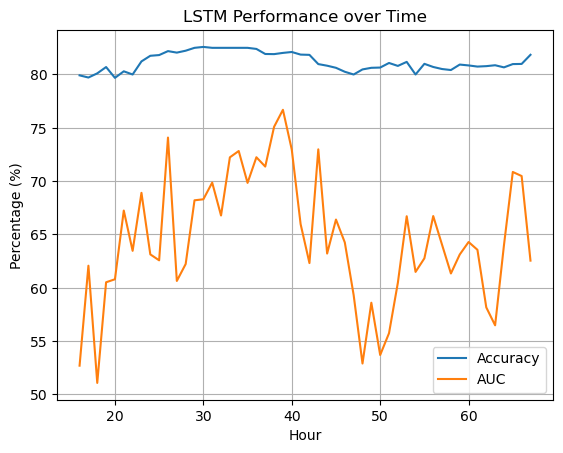

In [43]:
import matplotlib.pyplot as plt

# 假设你已有：
# results = [(t, mean_acc, mean_auc), ...]   # t 从 0 到 T-1，对应真实小时为 16+t

hours = [16 + t for t, _, _ in results]
accs  = [acc       for _, acc, _ in results]
aucs  = [auc       for _, _, auc in results]

plt.figure()
plt.plot(hours, accs)
plt.plot(hours, aucs)
plt.xlabel('Hour')
plt.ylabel('Percentage (%)')
plt.title('LSTM Performance over Time')
plt.legend(['Accuracy', 'AUC'])
plt.grid(True)
plt.show()


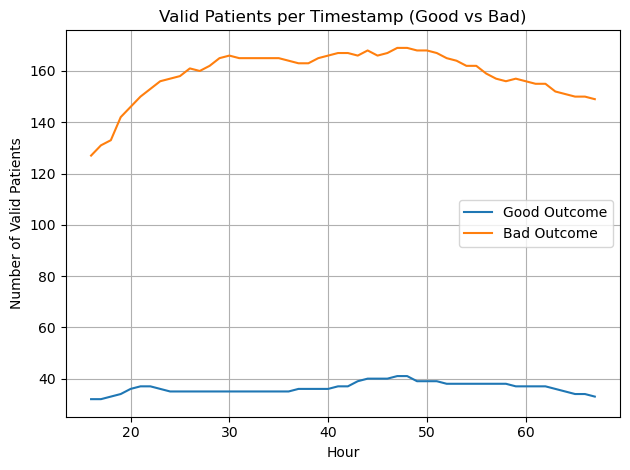

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已有：
#   X.shape = (N_patients, T, C)
#   y.shape = (N_patients,), 且 1=Good, 0=Bad

N, T, C = X.shape

# 统计每个时间点的 Good/Bad 有效病人数量
good_counts = []
bad_counts  = []
for t in range(T):
    # mask_t: 该时间点上至少有一个特征非零的病人
    mask_t = ~(np.all(X[:, t, :] == 0, axis=1))
    good_counts.append(np.sum(mask_t & (y == 1)))
    bad_counts.append( np.sum(mask_t & (y == 0)))

# 如果你的起始小时是 16h，则真实小时列表如下；否则直接用 t
hours = [16 + t for t in range(T)]

# 绘图
plt.figure()
plt.plot(hours, good_counts, label='Good Outcome')
plt.plot(hours, bad_counts,  label='Bad Outcome')
plt.xlabel('Hour')
plt.ylabel('Number of Valid Patients')
plt.title('Valid Patients per Timestamp (Good vs Bad)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
# —— 6. 按时间点展平 —— 
# 定义：只有当所有特征都不为 0 时，认为该时间戳“有效”
mask = ~(np.all(X == 0, axis=2))      # shape = (N_patients, T)
total_timepoints = int(mask.sum())   # 总有效时间戳数

# 预分配展平后的数组
C = X.shape[2]
X_flat = np.zeros((total_timepoints, C), dtype=X.dtype)
y_flat = np.zeros((total_timepoints,), dtype=y.dtype)
groups_flat = []  # 可以用 list，再根据需要转成 np.array 或 pandas.Series

idx = 0
for i in range(X.shape[0]):
    valid_ts = np.where(mask[i])[0]   # 该病人所有有效的时间索引
    for t in valid_ts:
        X_flat[idx] = X[i, t]         # 取出 shape=(C,)
        y_flat[idx] = y[i]            # 标签沿用病人标签
        groups_flat.append(groups[i]) # 病人 ID
        idx += 1

# 检查
print("展平后：")
print(f"  X_flat.shape = {X_flat.shape}   # (总有效时间戳, 特征数)")
print(f"  y_flat.shape = {y_flat.shape}   # (总有效时间戳,)")
print(f"  groups_flat 长度 = {len(groups_flat)}")

# （可选）转成 NumPy array
groups_flat = np.array(groups_flat)

# —— 7. 用 GroupKFold 按时间点分组交叉验证示例 —— 
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_flat, y_flat, groups_flat), 1):
    print(f"Fold {fold}: train {len(train_idx)} / test {len(test_idx)}")

#X, y, groups=X_flat, y_flat, groups_flat

展平后：
  X_flat.shape = (10149, 95)   # (总有效时间戳, 特征数)
  y_flat.shape = (10149,)   # (总有效时间戳,)
  groups_flat 长度 = 10149
Fold 1: train 8122 / test 2027
Fold 2: train 8118 / test 2031
Fold 3: train 8118 / test 2031
Fold 4: train 8118 / test 2031
Fold 5: train 8120 / test 2029


In [40]:
import numpy as np
from sklearn.model_selection import GroupKFold
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def cross_validate(X, y, groups, n_splits=5, lstm_epochs=20, mlp_epochs=20, batch_size=8):
    """
    通用 CV：根据 X.ndim 自动选择模型
    - 如果 X.ndim == 3，构建 LSTM 模型，输入 (T, C)
    - 如果 X.ndim == 2，构建简单 MLP，输入 (C,)
    """
    cv = GroupKFold(n_splits=n_splits)
    accs, aucs = [], []
    for fold, (tr_idx, te_idx) in enumerate(cv.split(X, y, groups), 1):
        print(f"\n--- Fold {fold} ---")
        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        print(" train balance:", Counter(y_tr))
        print("  test balance:", Counter(y_te))

        # —— 根据维度选择模型 —— 
        if X.ndim == 3:
            T, C = X_tr.shape[1], X_tr.shape[2]
            model = Sequential([
                LSTM(64, input_shape=(T, C), return_sequences=True),
                Dropout(0.2),
                LSTM(12, return_sequences=False),
                Dropout(0.2),
                Dense(1, activation='sigmoid')
            ])
            epochs = lstm_epochs
        elif X.ndim == 2:
            C = X_tr.shape[1]
            model = Sequential([
                Dense(64, input_shape=(C,), activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.2),
                Dense(1, activation='sigmoid')
            ])
            epochs = mlp_epochs
        else:
            raise ValueError("只支持 2D (flat) 或 3D (time series) 输入")

        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

        # —— 训练 —— 
        model.fit(X_tr, y_tr,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=2)

        # —— 评估 —— 
        loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
        acc *= 100; auc *= 100
        print(f"Accuracy: {acc:.2f}%, AUC: {auc:.2f}%")

        accs.append(acc); aucs.append(auc)

    print("\n=== Cross‐Validation Results ===")
    print(f"Mean Accuracy: {np.mean(accs):.2f}% ± {np.std(accs):.2f}%")
    print(f"Mean AUC     : {np.mean(aucs):.2f}% ± {np.std(aucs):.2f}%")

# —— 用法 —— 
# 对原始时序数据：
cross_validate(X, y, groups, lstm_epochs=20)

# 对扁平化后数据：
cross_validate(X_flat, y_flat, groups_flat, mlp_epochs=10)



--- Fold 1 ---
 train balance: Counter({0.0: 162, 1.0: 33})
  test balance: Counter({0.0: 38, 1.0: 11})
Epoch 1/20


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 - 3s - 125ms/step - accuracy: 0.7897 - auc: 0.5594 - loss: 0.5519
Epoch 2/20
25/25 - 0s - 18ms/step - accuracy: 0.8308 - auc: 0.5843 - loss: 0.4621
Epoch 3/20
25/25 - 0s - 18ms/step - accuracy: 0.8308 - auc: 0.5605 - loss: 0.4547
Epoch 4/20
25/25 - 0s - 18ms/step - accuracy: 0.8359 - auc: 0.7027 - loss: 0.4190
Epoch 5/20
25/25 - 0s - 19ms/step - accuracy: 0.8359 - auc: 0.6261 - loss: 0.4288
Epoch 6/20
25/25 - 0s - 18ms/step - accuracy: 0.8410 - auc: 0.7330 - loss: 0.4036
Epoch 7/20
25/25 - 1s - 27ms/step - accuracy: 0.8513 - auc: 0.7351 - loss: 0.3948
Epoch 8/20
25/25 - 0s - 18ms/step - accuracy: 0.8513 - auc: 0.8027 - loss: 0.3709
Epoch 9/20
25/25 - 0s - 18ms/step - accuracy: 0.8564 - auc: 0.7486 - loss: 0.3819
Epoch 10/20
25/25 - 0s - 18ms/step - accuracy: 0.8615 - auc: 0.7580 - loss: 0.3781
Epoch 11/20
25/25 - 1s - 28ms/step - accuracy: 0.8667 - auc: 0.7607 - loss: 0.3722
Epoch 12/20
25/25 - 0s - 18ms/step - accuracy: 0.8667 - auc: 0.8057 - loss: 0.3456
Epoch 13/20
25/25 - 0s 

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1016/1016 - 2s - 2ms/step - accuracy: 0.6832 - auc: 0.5191 - loss: 141708832.0000
Epoch 2/10
1016/1016 - 1s - 1ms/step - accuracy: 0.7129 - auc: 0.5239 - loss: 69580680.0000
Epoch 3/10
1016/1016 - 1s - 1ms/step - accuracy: 0.7204 - auc: 0.5150 - loss: 118807208.0000
Epoch 4/10
1016/1016 - 1s - 1ms/step - accuracy: 0.6630 - auc: 0.5134 - loss: 80389448.0000
Epoch 5/10
1016/1016 - 1s - 1ms/step - accuracy: 0.7155 - auc: 0.5240 - loss: 45783544.0000
Epoch 6/10
1016/1016 - 1s - 1ms/step - accuracy: 0.7201 - auc: 0.5112 - loss: 39538276.0000
Epoch 7/10
1016/1016 - 1s - 1ms/step - accuracy: 0.6878 - auc: 0.5166 - loss: 48069128.0000
Epoch 8/10
1016/1016 - 1s - 1ms/step - accuracy: 0.7917 - auc: 0.5188 - loss: 20708968.0000
Epoch 9/10
1016/1016 - 1s - 1ms/step - accuracy: 0.8104 - auc: 0.5104 - loss: 1032668.4375
Epoch 10/10
1016/1016 - 1s - 1ms/step - accuracy: 0.8119 - auc: 0.5153 - loss: 10999527.0000
Accuracy: 81.11%, AUC: 50.24%

--- Fold 2 ---
 train balance: Counter({0.0: 6701, 1.0: 14

In [36]:
# —— 2. 设置交叉验证和保存结果的容器 —— 
cv        = GroupKFold(n_splits=5)
cvscores  = []
auc_scores= []
preds_all = []

# —— 3. 在每个 fold 中重新构建模型、训练、评估 —— 
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))
    
    # —— 3.1 定义 Keras 模型 —— 
    model = Sequential([
        LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(12, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # —— 3.2 训练 —— 
    model.fit(
        X_tr, y_tr,
        batch_size=8,
        epochs=20,    # 可调整
        verbose=2
    )
    
    # —— 3.3 评估 —— 
    scores = model.evaluate(X_te, y_te, verbose=0)
    acc    = scores[1] * 100
    auc    = scores[2] * 100
    print(f"Accuracy: {acc:.2f}%, AUC: {auc:.2f}%")
    
    # —— 3.4 保存结果 —— 
    cvscores.append(acc)
    auc_scores.append(auc)
    
    # —— 3.5 预测并存储所有 fold 的输出 —— 
    preds = model.predict(X_te, verbose=0).flatten()
    preds_all.extend(preds)

# —— 4. 汇总所有 fold —— 
print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")


--- Fold 1 ---
 train balance: Counter({0.0: 6611, 1.0: 1511})
  test balance: Counter({0.0: 1644, 1.0: 383})


IndexError: tuple index out of range

In [32]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import numpy as np
import tensorflow as tf
from collections import Counter

# 假设 X, y, groups 都已准备好
cv = GroupKFold(n_splits=5)
cvscores, auc_scores, preds_all = [], [], []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))
    
    # 计算类别权重
    classes = np.unique(y_tr)
    weights = compute_class_weight('balanced', classes=classes, y=y_tr)
    class_weight = dict(zip(classes, weights))
    print(" class weights:", class_weight)
    
    # 定义模型
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(12),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    # 训练时传入 class_weight
    model.fit(
        X_tr, y_tr,
        batch_size=8,
        epochs=20,
        verbose=2,
        class_weight=class_weight
    )
    
    # 评估
    loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%, AUC: {auc*100:.2f}%")
    cvscores.append(acc*100)
    auc_scores.append(auc*100)
    
    preds_all.extend(model.predict(X_te).flatten())

# 汇总
print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")



--- Fold 1 ---
 train balance: Counter({0.0: 162, 1.0: 33})
  test balance: Counter({0.0: 38, 1.0: 11})
 class weights: {0.0: 0.6018518518518519, 1.0: 2.9545454545454546}
Epoch 1/20
25/25 - 3s - 132ms/step - accuracy: 0.2308 - auc: 0.4740 - loss: 0.7404
Epoch 2/20
25/25 - 1s - 21ms/step - accuracy: 0.3128 - auc: 0.5711 - loss: 0.7102
Epoch 3/20
25/25 - 1s - 20ms/step - accuracy: 0.2974 - auc: 0.5415 - loss: 0.7199
Epoch 4/20
25/25 - 1s - 20ms/step - accuracy: 0.3385 - auc: 0.5105 - loss: 0.7181
Epoch 5/20
25/25 - 0s - 20ms/step - accuracy: 0.3641 - auc: 0.5632 - loss: 0.6976
Epoch 6/20
25/25 - 1s - 26ms/step - accuracy: 0.4308 - auc: 0.5618 - loss: 0.6945
Epoch 7/20
25/25 - 0s - 19ms/step - accuracy: 0.4615 - auc: 0.5580 - loss: 0.6927
Epoch 8/20
25/25 - 0s - 19ms/step - accuracy: 0.4154 - auc: 0.5403 - loss: 0.6948
Epoch 9/20
25/25 - 1s - 27ms/step - accuracy: 0.4513 - auc: 0.6158 - loss: 0.6725
Epoch 10/20
25/25 - 0s - 19ms/step - accuracy: 0.4718 - auc: 0.5374 - loss: 0.6912
Epoch 

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# 假设 X, y, groups 已经准备好
cv = GroupKFold(n_splits=5)
cvscores, auc_scores = [], []

# 可选：定义 Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.pow(1 - p_t, gamma) * bce
    return loss_fn

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups), 1):
    print(f"\n--- Fold {fold} ---")
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    print(" train balance:", Counter(y_tr))
    print("  test balance:", Counter(y_te))

    # —— 1. 过采样少数类 —— 
    n_s, seq_len, n_feat = X_tr.shape
    X_flat = X_tr.reshape(n_s, -1)
    ros = RandomOverSampler(random_state=42)
    X_res_flat, y_res = ros.fit_resample(X_flat, y_tr)
    X_res = X_res_flat.reshape(-1, seq_len, n_feat)
    print(" after oversampling:", Counter(y_res))

    # —— 2. 定义模型（示例用双向 LSTM） —— 
    model = Sequential([
        Input(shape=(seq_len, n_feat)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        LSTM(12),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=focal_loss(),  # 或者用 'binary_crossentropy'
        optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # —— 3. 训练 —— 
    model.fit(
        X_res, y_res,
        batch_size=8,
        epochs=20,
        verbose=2
    )

    # —— 4. 评估 —— 
    loss, acc, auc = model.evaluate(X_te, y_te, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%, AUC: {auc*100:.2f}%")
    cvscores.append(acc*100)
    auc_scores.append(auc*100)

print("\n=== Cross‐Validation Results ===")
print(f"Mean Accuracy: {np.mean(cvscores):.2f}% ± {np.std(cvscores):.2f}%")
print(f"Mean AUC     : {np.mean(auc_scores):.2f}% ± {np.std(auc_scores):.2f}%")



--- Fold 1 ---
 train balance: Counter({0.0: 162, 1.0: 33})
  test balance: Counter({0.0: 38, 1.0: 11})
 after oversampling: Counter({0.0: 162, 1.0: 162})
Epoch 1/20
41/41 - 5s - 111ms/step - accuracy: 0.5123 - auc: 0.4611 - loss: 0.0832
Epoch 2/20
41/41 - 1s - 36ms/step - accuracy: 0.5000 - auc: 0.5163 - loss: 0.0772
Epoch 3/20
41/41 - 1s - 31ms/step - accuracy: 0.5031 - auc: 0.5341 - loss: 0.0759
Epoch 4/20
41/41 - 1s - 21ms/step - accuracy: 0.4877 - auc: 0.5512 - loss: 0.0750
Epoch 5/20
41/41 - 1s - 32ms/step - accuracy: 0.4969 - auc: 0.5633 - loss: 0.0730
Epoch 6/20
41/41 - 1s - 21ms/step - accuracy: 0.5093 - auc: 0.5905 - loss: 0.0712
Epoch 7/20
41/41 - 1s - 32ms/step - accuracy: 0.5216 - auc: 0.6148 - loss: 0.0696
Epoch 8/20
41/41 - 1s - 21ms/step - accuracy: 0.5247 - auc: 0.6176 - loss: 0.0698
Epoch 9/20
41/41 - 1s - 32ms/step - accuracy: 0.5123 - auc: 0.6649 - loss: 0.0663
Epoch 10/20
41/41 - 1s - 21ms/step - accuracy: 0.5154 - auc: 0.6391 - loss: 0.0679
Epoch 11/20
41/41 - 1s